# set hyperparameters  
- Epoch: 30  
- Batch Size: 32

In [1]:
import torch
import os
import cv2
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import numpy as np
import pylab
import torchvision.transforms as transforms
import torch.nn.functional as F

# select device
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print(DEVICE)

# set epoch, batch size
EPOCH = 30
BATCH_SIZE = 32

cuda


# Data Augmentation  
: using torchvision.transforms()  
</br>
***Function get_transform(isTest)***  
- *isTest*: boolean type parameter, True - test dataset, False -  train dataset  
- If the dataset is train dataset, apply *transforms.RandomHorizontalFlip()* and *transforms.ColorJitter()*.  
- *transforms.RandomHorizontalFlip(0.5)*: reversed left and right with 50% probability.  
- *transforms.ColorJitter(brightness=(0.2, 2), contrast=(0.3, 2), saturation=(0.2, 2), hue=(-0.3, 0.3))*: Randomly change the brightness, contrast, saturation and hue of an image.

In [2]:
# return transforms based on whether the dataset is test dataset.
def get_transform(isTest):
    trans = []
    if not isTest:    # if the dataset is not Test Dataset
        trans.append(transforms.ToPILImage())
        trans.append(transforms.RandomHorizontalFlip(0.5))    # reversed left and right with 50% probability.
        trans.append(transforms.ColorJitter(brightness=(0.2, 2),   # Randomly change the brightness, contrast, saturation and hue of an image
                               contrast=(0.3, 2), 
                               saturation=(0.2, 2), 
                               hue=(-0.3, 0.3)))
        
    trans.append(transforms.ToTensor())    # convert to tensor
    trans.append(transforms.Normalize(mean=[0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]))    # Normalize a tensor image with mean and standard deviation
    
    return transforms.Compose(trans)

# Custom Dataset

In [3]:
class MyDataset(Dataset):
    def __init__(self, image_dir, label, transforms=None, test=False):
        self.image_dir =  image_dir
        self.label = label
        self.image_list = os.listdir(self.image_dir)
        self.transforms = transforms
        self.test_mode = test
    
    def __len__(self):
        return len(self.image_list)
    
    def __getitem__(self, idx):
        # if torch.is_tensor(idx):
        #    idx = idx.tolist()
        
        image_name = os.path.join(self.image_dir, self.image_list[idx])
        image = cv2.imread(image_name)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (224, 224), cv2.INTER_AREA)
        
        # Apply transforms
        image = self.transforms(image)
        
        if self.test_mode:
            return(image, self.image_list[idx])
        else:
            return (image, self.label)

# ConcatDataset & DataLoader

In [4]:
balancing_train = MyDataset("../input/yoga-classification-dataset/yoga_6_classes_trainval_images/balancing_train", 0, get_transform(False))
inverted_train = MyDataset("../input/yoga-classification-dataset/yoga_6_classes_trainval_images/inverted_train", 1, get_transform(False))
reclining_train = MyDataset("../input/yoga-classification-dataset/yoga_6_classes_trainval_images/reclining_train", 2, get_transform(False))
sitting_train = MyDataset("../input/yoga-classification-dataset/yoga_6_classes_trainval_images/sitting_train", 3, get_transform(False))
standing_train = MyDataset("../input/yoga-classification-dataset/yoga_6_classes_trainval_images/standing_train", 4, get_transform(False))
wheel_train = MyDataset("../input/yoga-classification-dataset/yoga_6_classes_trainval_images/wheel_train", 5, get_transform(False))
train_set = ConcatDataset([balancing_train, inverted_train, reclining_train, sitting_train, standing_train, wheel_train])
print("Number of Traning set images: ", len(train_set))

balancing_valid = MyDataset("../input/yoga-classification-dataset/yoga_6_classes_trainval_images/balancing_valid", 0, get_transform(True))
inverted_valid = MyDataset("../input/yoga-classification-dataset/yoga_6_classes_trainval_images/inverted_valid", 1, get_transform(True))
reclining_valid = MyDataset("../input/yoga-classification-dataset/yoga_6_classes_trainval_images/reclining_valid", 2, get_transform(True))
sitting_valid = MyDataset("../input/yoga-classification-dataset/yoga_6_classes_trainval_images/sitting_valid", 3, get_transform(True))
standing_valid = MyDataset("../input/yoga-classification-dataset/yoga_6_classes_trainval_images/standing_valid", 4, get_transform(True))
wheel_valid = MyDataset("../input/yoga-classification-dataset/yoga_6_classes_trainval_images/wheel_valid", 5, get_transform(True))
val_set = ConcatDataset([balancing_valid, inverted_valid, reclining_valid, sitting_valid, standing_valid, wheel_valid])
print("Number of Validation set images: ", len(val_set))

train_loader = DataLoader(train_set,
                          batch_size=BATCH_SIZE,
                          shuffle = True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False)
print("load dataloader")


Number of Traning set images:  5400
Number of Validation set images:  600
load dataloader


# Create Model, Optimizer, and Schedular  
- learning rate: 1e-4  
- weight decay: 1e-4  
</br>
- model: pretrained resnet18  
</br>
- optimizer: *Adam()*. 
- scheduler: *optim.lr_scheduler.StepLR()*, *step_size* = 10, *gamma* = 0.01

In [5]:
import torchvision.models as models
import torch.optim as optim
import torch.nn as nn

lr = 1e-4    # learing rate
weight_decay = 1e-4    # weight decay

model = models.resnet18(pretrained=True)

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 6)
model = model. to(DEVICE)
print(model)

optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay = weight_decay)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                   step_size=10,
                                                   gamma=0.01)

print("create model, optimizer, and schedular")

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# Train code

In [6]:
# to save train loss and accuracy
train_loss = np.zeros(EPOCH)
train_accuracy = np.zeros(EPOCH)

In [7]:
def train(model, train_loader, optimizer, epoch):
    model.train()
    correct = 0
    for i, (image, target) in enumerate(train_loader):
        image, target = image.to(DEVICE), target.to(DEVICE)
        output = model(image)
        optimizer.zero_grad()
        loss = F.cross_entropy(output, target).to(DEVICE)
        loss.backward()
        optimizer.step()
        
        # calculate train accuarcy
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        if i % 10 == 0:
            print("Train Epoch: {} [{}/{} ({:.0f})%]\Loss {:.6f}".
                 format(epoch, i*len(image), len(train_loader.dataset), 100.*i / len(train_loader), loss.item()))
    
    train_loss[epoch] = loss.item()
    train_accuracy[epoch] = correct / len(train_loader.dataset)
        

# Evaluation code

In [8]:
# to save validation loss and accuracy
val_loss = np.zeros(EPOCH)
val_accuracy = np.zeros(EPOCH)

In [9]:
def evaluate(model, val_loader, epoch):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for (image, target) in val_loader:
            image, target = image.to(DEVICE), target.to(DEVICE)
            output = model(image)
            
            test_loss = F.cross_entropy(output, target, reduction='sum').item()
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()
            
    test_loss /= len(val_loader.dataset)
    test_accuracy = 100. * correct / len(val_loader.dataset)

    val_loss[epoch] = test_loss
    val_accuracy[epoch] = test_accuracy * 0.01
    
    return test_loss, test_accuracy

# AutoTuner

## Class Config  
It is a Class that defines the list of parameters to use for AutoTuner class.  
- Variables  
    - 1. Class Variable 
        - *optim_list*: 1- SGD, 2 - Adam, 3 - RMSprop, 4 - Adagrad  
    - 2. Instance Variable  
        - *lr_list*: list of learing rate  
        - *batch_size_list*: list of batch size  
        - *epoch_list*: list of epoch  
- Function  
    - *print_info()*: print the information of variables.

In [10]:
class Config:
    
    optim_list = [1, 2, 3, 4]
    
    def __init__(self, lr_list = [0.1, 0.01, 0.001, 0.0001], batch_size_list = [32, 64, 128], epoch_list = [20, 30, 40]):
        self.lr_list = lr_list
        self.batch_size_list = batch_size_list
        self.epoch_list = epoch_list
    
    def print_info(self):
        print('optim_list = [{}, {}, {}, {}], length = {}'.format('SGD', 'Adam', 'RMSprop', 'Adagrad', len(Config.optim_list)))
        print('lr_list = {}, length = {}'.format(self.lr_list, len(self.lr_list)))
        print('batch_size_list = {}, length = {}'.format(self.batch_size_list, len(self.batch_size_list)))
        print('epoch_list = {}, length = {}'.format(self.epoch_list, len(self.epoch_list)))

## Class AutoTuner  
- Variables
    - *train_set*: train dataset  
    - *val_set*: validation dataset  
    - *config*: object of Config class (list of parameters)  
    - *model*: model to use
    - *best_comb*: list type, best combination of the parameter list  
- Functions 
    - *__len__()*: return the number of list combinations
    - *tuner()*: return the best list combination

In [11]:
from torchvision import models as models
import torch.nn as nn
import torch.optim as optim

#AutoTuner class
class AutoTuner (nn.Module) :
    def __init__(self, train_set, val_set, config) : #initialize the parameter
        super().__init__()
        self.model = models.resnet18(pretrained = True) 
        self.train_set = train_set
        self.val_set = val_set
        self.config = config
        self.best_comb = None
  

    def __len__ (self) : #sum of hyperparameter combination
        return len(self.config.lr_list) * len(self.config.optim_list) * len(self.config.batch_size_list) * len(self.config.epoch_list)


    def tuner (self)  : #tuner function
        best = 0
        self.best_comb = []

  

        for lr in self.config.lr_list : #learning rate list
            for optims in self.config.optim_list : #optimizer list
                for batch_size in self.config.batch_size_list : #batch size list
                    for epochs in self.config.epoch_list : #epoch list
                        #train and validation data set loader
                        train_loader = DataLoader(self.train_set, batch_size= batch_size, shuffle = True)
                        val_loader = DataLoader(self.val_set, batch_size = batch_size, shuffle = False)
                        

                        #model initialize
                        model = self.model
                        num_ftrs = model.fc.in_features
                        model.fc = nn.Linear(num_ftrs, 6)
                        model = model.to(DEVICE)

                        #optimizer choose
                        if optims == 1 :
                            optimizer = optim.SGD(model.parameters(), lr = lr)
                            print("Hyperparameter, learning rate: {}, optimizer: {}, batch_size: {}, epoch: {}".format(lr, "SGD", batch_size, epochs))
                        elif optims == 2:
                            optimizer = optim.Adam(model.parameters(), lr = lr)
                            print("Hyperparameter, learning rate: {}, optimizer: {}, batch_size: {}, epoch: {}".format(lr, "Adam", batch_size, epochs))

                        elif optims == 3:
                            optimizer = optim.RMSprop(model.parameters(), lr=lr)
                            print("Hyperparameter, learning rate: {}, optimizer: {}, batch_size: {}, epoch: {}".format(lr, "RMSprop", batch_size, epochs))

                        elif optims == 4:
                            optimizer = optim.Adagrad(model.parameters(), lr=lr)
                            print("Hyperparameter, learning rate: {}, optimizer: {}, batch_size: {}, epoch: {}".format(lr, "Adagrad", batch_size, epochs))



                        for epoch in range(epochs) :
                            #train and test
                            train(model, train_loader, optimizer, epoch)
                            test_loss, test_accuracy = evaluate(model, val_loader)

                            #input the hyperparameter combination in the list
                            if test_accuracy > best :
                                self.best_comb = []

                                if optims == 1 :
                                    self.best_comb.append("SGD")
                                elif optims == 2 :
                                    self.best_comb.append("Adam")
                                elif optims == 3 :
                                    self.best_comb.append("RMSprop")
                                elif optims == 4 :
                                    self.best_comb.append("Adagrad")  

                                self.best_comb.append(lr)
                                self.best_comb.append(batch_size)
                                best = test_accuracy

                            print('[{}] Test Loss : {:.4f}, Accuracy : {:.4f}%'.format(epoch, test_loss, test_accuracy))

        print("finish train\n")
        print("best acc: ", best)
        
        return self.best_comb
    
    

## Run AutoTuner

In [12]:
# Config().print_info()    # print information
# a = AutoTuner(train_set, val_set, Config()).tuner()

Train Epoch: 0 [0/5400 (0)%]\Loss 1.861568
Train Epoch: 0 [320/5400 (6)%]\Loss 1.613031
Train Epoch: 0 [640/5400 (12)%]\Loss 1.204039
Train Epoch: 0 [960/5400 (18)%]\Loss 1.322524
Train Epoch: 0 [1280/5400 (24)%]\Loss 0.966800
Train Epoch: 0 [1600/5400 (30)%]\Loss 0.842035
Train Epoch: 0 [1920/5400 (36)%]\Loss 0.953811
Train Epoch: 0 [2240/5400 (41)%]\Loss 0.726584
Train Epoch: 0 [2560/5400 (47)%]\Loss 0.805748
Train Epoch: 0 [2880/5400 (53)%]\Loss 0.608719
Train Epoch: 0 [3200/5400 (59)%]\Loss 0.775703
Train Epoch: 0 [3520/5400 (65)%]\Loss 0.794120
Train Epoch: 0 [3840/5400 (71)%]\Loss 0.942533
Train Epoch: 0 [4160/5400 (77)%]\Loss 0.541046
Train Epoch: 0 [4480/5400 (83)%]\Loss 0.442235
Train Epoch: 0 [4800/5400 (89)%]\Loss 0.500921
Train Epoch: 0 [5120/5400 (95)%]\Loss 0.642346
[0] Test Loss: 0.0071, Accuracy: 83.3333%


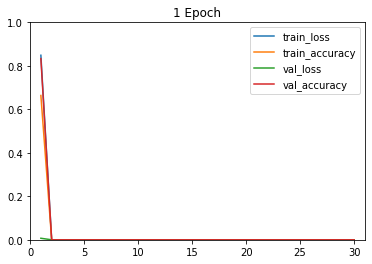

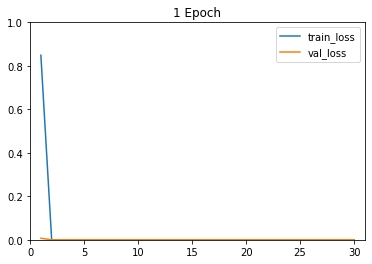

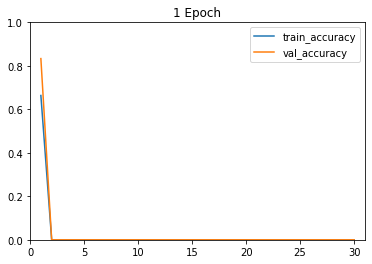

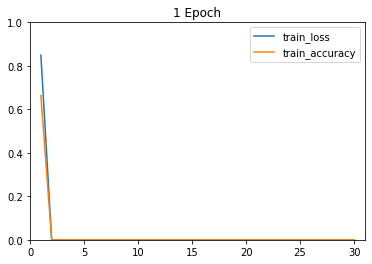

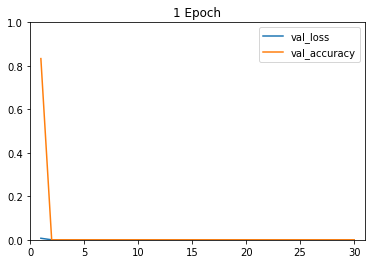

Train Epoch: 1 [0/5400 (0)%]\Loss 0.355833
Train Epoch: 1 [320/5400 (6)%]\Loss 0.361266
Train Epoch: 1 [640/5400 (12)%]\Loss 0.544371
Train Epoch: 1 [960/5400 (18)%]\Loss 0.440389
Train Epoch: 1 [1280/5400 (24)%]\Loss 0.548544
Train Epoch: 1 [1600/5400 (30)%]\Loss 0.537824
Train Epoch: 1 [1920/5400 (36)%]\Loss 0.498924
Train Epoch: 1 [2240/5400 (41)%]\Loss 0.433910
Train Epoch: 1 [2560/5400 (47)%]\Loss 0.396496
Train Epoch: 1 [2880/5400 (53)%]\Loss 0.448042
Train Epoch: 1 [3200/5400 (59)%]\Loss 0.469977
Train Epoch: 1 [3520/5400 (65)%]\Loss 0.351586
Train Epoch: 1 [3840/5400 (71)%]\Loss 0.506243
Train Epoch: 1 [4160/5400 (77)%]\Loss 0.398862
Train Epoch: 1 [4480/5400 (83)%]\Loss 0.739507
Train Epoch: 1 [4800/5400 (89)%]\Loss 0.883470
Train Epoch: 1 [5120/5400 (95)%]\Loss 0.330934
[1] Test Loss: 0.0074, Accuracy: 87.6667%


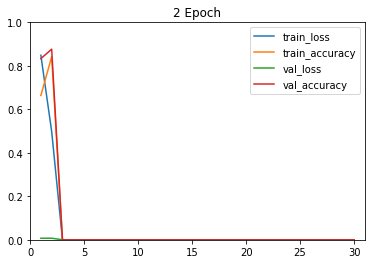

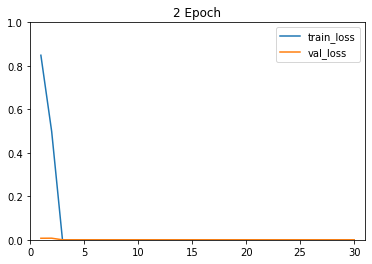

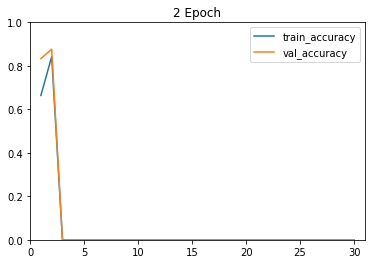

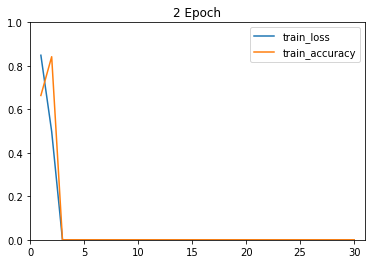

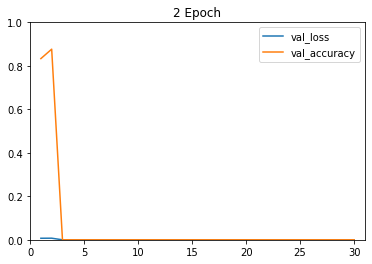

Train Epoch: 2 [0/5400 (0)%]\Loss 0.333035
Train Epoch: 2 [320/5400 (6)%]\Loss 0.174616
Train Epoch: 2 [640/5400 (12)%]\Loss 0.159553
Train Epoch: 2 [960/5400 (18)%]\Loss 0.387648
Train Epoch: 2 [1280/5400 (24)%]\Loss 0.309805
Train Epoch: 2 [1600/5400 (30)%]\Loss 0.287879
Train Epoch: 2 [1920/5400 (36)%]\Loss 0.261186
Train Epoch: 2 [2240/5400 (41)%]\Loss 0.198568
Train Epoch: 2 [2560/5400 (47)%]\Loss 0.297966
Train Epoch: 2 [2880/5400 (53)%]\Loss 0.306109
Train Epoch: 2 [3200/5400 (59)%]\Loss 0.321567
Train Epoch: 2 [3520/5400 (65)%]\Loss 0.333081
Train Epoch: 2 [3840/5400 (71)%]\Loss 0.261349
Train Epoch: 2 [4160/5400 (77)%]\Loss 0.265654
Train Epoch: 2 [4480/5400 (83)%]\Loss 0.146703
Train Epoch: 2 [4800/5400 (89)%]\Loss 0.269420
Train Epoch: 2 [5120/5400 (95)%]\Loss 0.326196
[2] Test Loss: 0.0064, Accuracy: 88.5000%


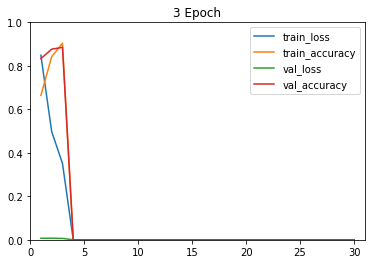

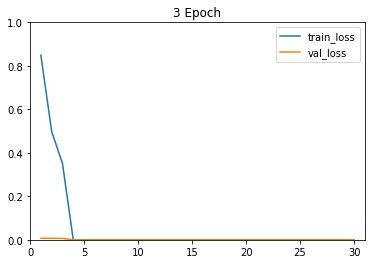

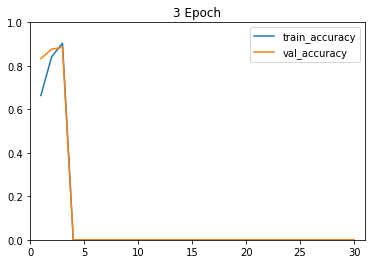

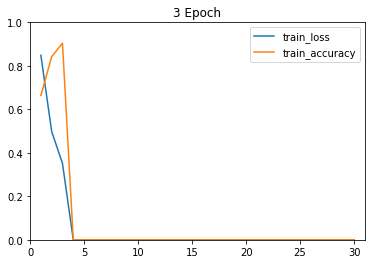

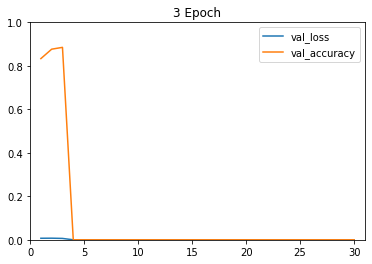

Train Epoch: 3 [0/5400 (0)%]\Loss 0.144461
Train Epoch: 3 [320/5400 (6)%]\Loss 0.167016
Train Epoch: 3 [640/5400 (12)%]\Loss 0.121138
Train Epoch: 3 [960/5400 (18)%]\Loss 0.235322
Train Epoch: 3 [1280/5400 (24)%]\Loss 0.138561
Train Epoch: 3 [1600/5400 (30)%]\Loss 0.084232
Train Epoch: 3 [1920/5400 (36)%]\Loss 0.424521
Train Epoch: 3 [2240/5400 (41)%]\Loss 0.148369
Train Epoch: 3 [2560/5400 (47)%]\Loss 0.261227
Train Epoch: 3 [2880/5400 (53)%]\Loss 0.411424
Train Epoch: 3 [3200/5400 (59)%]\Loss 0.294475
Train Epoch: 3 [3520/5400 (65)%]\Loss 0.065051
Train Epoch: 3 [3840/5400 (71)%]\Loss 0.295920
Train Epoch: 3 [4160/5400 (77)%]\Loss 0.092329
Train Epoch: 3 [4480/5400 (83)%]\Loss 0.130191
Train Epoch: 3 [4800/5400 (89)%]\Loss 0.316534
Train Epoch: 3 [5120/5400 (95)%]\Loss 0.340442
[3] Test Loss: 0.0081, Accuracy: 89.6667%


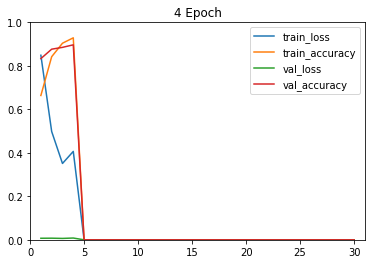

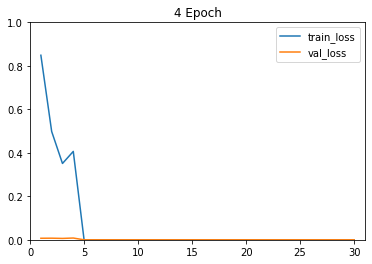

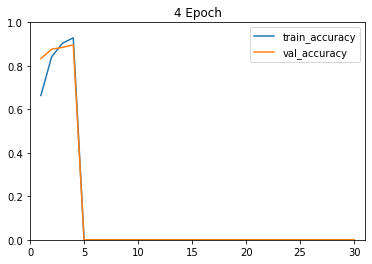

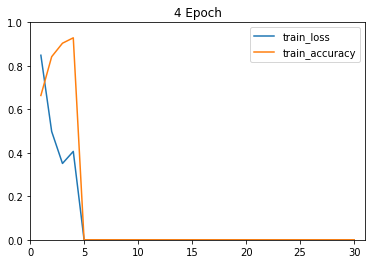

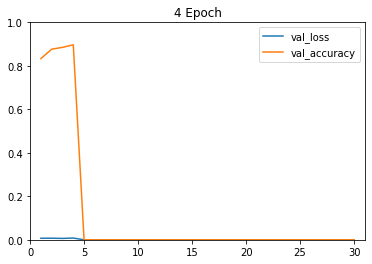

Train Epoch: 4 [0/5400 (0)%]\Loss 0.152042
Train Epoch: 4 [320/5400 (6)%]\Loss 0.356404
Train Epoch: 4 [640/5400 (12)%]\Loss 0.062094
Train Epoch: 4 [960/5400 (18)%]\Loss 0.105304
Train Epoch: 4 [1280/5400 (24)%]\Loss 0.195330
Train Epoch: 4 [1600/5400 (30)%]\Loss 0.134399
Train Epoch: 4 [1920/5400 (36)%]\Loss 0.095583
Train Epoch: 4 [2240/5400 (41)%]\Loss 0.081871
Train Epoch: 4 [2560/5400 (47)%]\Loss 0.308667
Train Epoch: 4 [2880/5400 (53)%]\Loss 0.148600
Train Epoch: 4 [3200/5400 (59)%]\Loss 0.038372
Train Epoch: 4 [3520/5400 (65)%]\Loss 0.078549
Train Epoch: 4 [3840/5400 (71)%]\Loss 0.116662
Train Epoch: 4 [4160/5400 (77)%]\Loss 0.060512
Train Epoch: 4 [4480/5400 (83)%]\Loss 0.111771
Train Epoch: 4 [4800/5400 (89)%]\Loss 0.047383
Train Epoch: 4 [5120/5400 (95)%]\Loss 0.108353
[4] Test Loss: 0.0049, Accuracy: 88.6667%


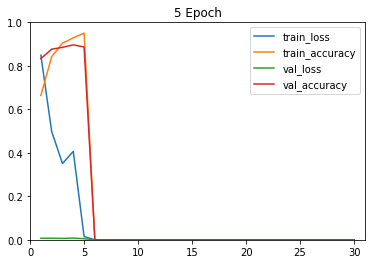

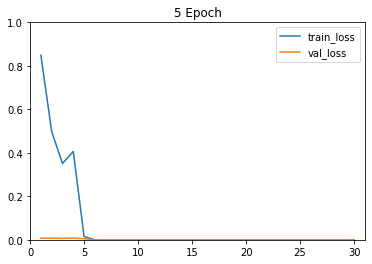

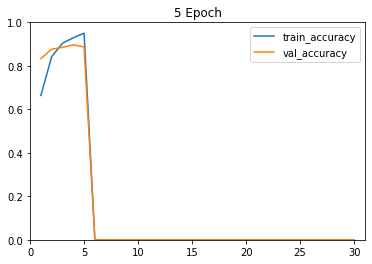

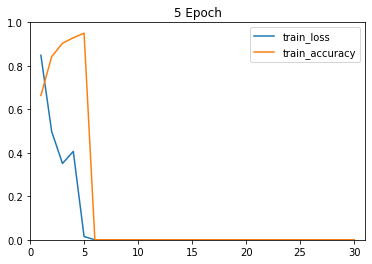

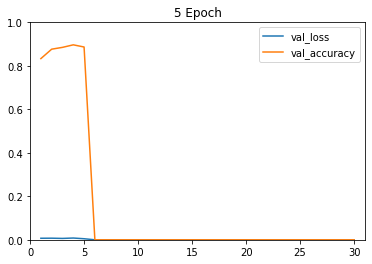

Train Epoch: 5 [0/5400 (0)%]\Loss 0.062691
Train Epoch: 5 [320/5400 (6)%]\Loss 0.056112
Train Epoch: 5 [640/5400 (12)%]\Loss 0.075529
Train Epoch: 5 [960/5400 (18)%]\Loss 0.166343
Train Epoch: 5 [1280/5400 (24)%]\Loss 0.075779
Train Epoch: 5 [1600/5400 (30)%]\Loss 0.189098
Train Epoch: 5 [1920/5400 (36)%]\Loss 0.297327
Train Epoch: 5 [2240/5400 (41)%]\Loss 0.305668
Train Epoch: 5 [2560/5400 (47)%]\Loss 0.055928
Train Epoch: 5 [2880/5400 (53)%]\Loss 0.246438
Train Epoch: 5 [3200/5400 (59)%]\Loss 0.339736
Train Epoch: 5 [3520/5400 (65)%]\Loss 0.087310
Train Epoch: 5 [3840/5400 (71)%]\Loss 0.162627
Train Epoch: 5 [4160/5400 (77)%]\Loss 0.046631
Train Epoch: 5 [4480/5400 (83)%]\Loss 0.086240
Train Epoch: 5 [4800/5400 (89)%]\Loss 0.111863
Train Epoch: 5 [5120/5400 (95)%]\Loss 0.085907
[5] Test Loss: 0.0070, Accuracy: 90.6667%


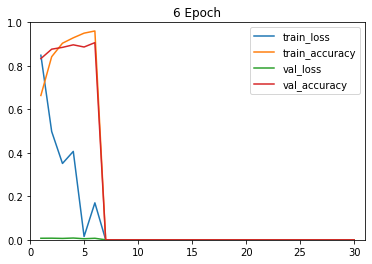

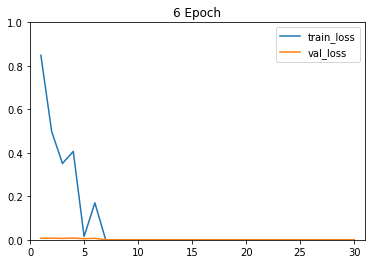

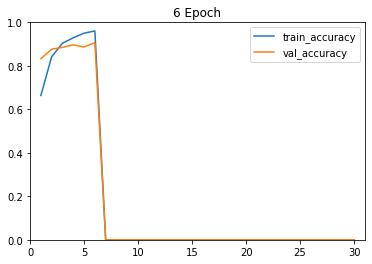

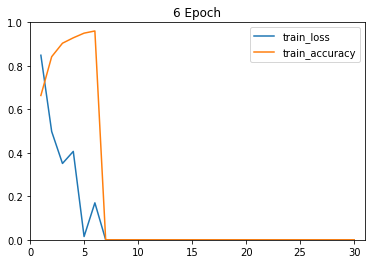

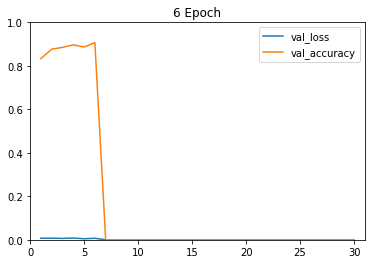

Train Epoch: 6 [0/5400 (0)%]\Loss 0.147204
Train Epoch: 6 [320/5400 (6)%]\Loss 0.061997
Train Epoch: 6 [640/5400 (12)%]\Loss 0.149432
Train Epoch: 6 [960/5400 (18)%]\Loss 0.167554
Train Epoch: 6 [1280/5400 (24)%]\Loss 0.026735
Train Epoch: 6 [1600/5400 (30)%]\Loss 0.211823
Train Epoch: 6 [1920/5400 (36)%]\Loss 0.083617
Train Epoch: 6 [2240/5400 (41)%]\Loss 0.048559
Train Epoch: 6 [2560/5400 (47)%]\Loss 0.133127
Train Epoch: 6 [2880/5400 (53)%]\Loss 0.160377
Train Epoch: 6 [3200/5400 (59)%]\Loss 0.033533
Train Epoch: 6 [3520/5400 (65)%]\Loss 0.042097
Train Epoch: 6 [3840/5400 (71)%]\Loss 0.045785
Train Epoch: 6 [4160/5400 (77)%]\Loss 0.179437
Train Epoch: 6 [4480/5400 (83)%]\Loss 0.127838
Train Epoch: 6 [4800/5400 (89)%]\Loss 0.143876
Train Epoch: 6 [5120/5400 (95)%]\Loss 0.036594
[6] Test Loss: 0.0031, Accuracy: 89.8333%


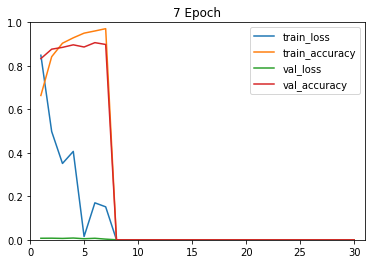

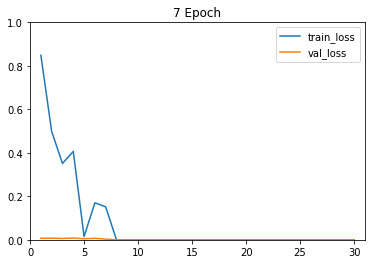

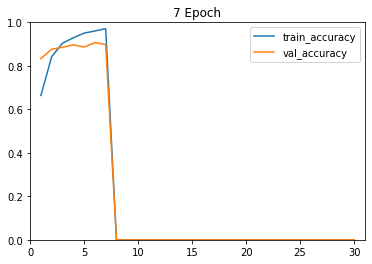

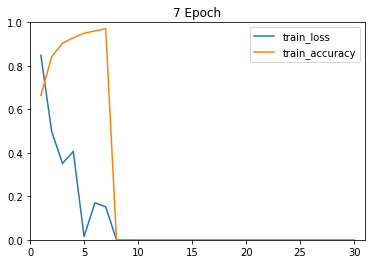

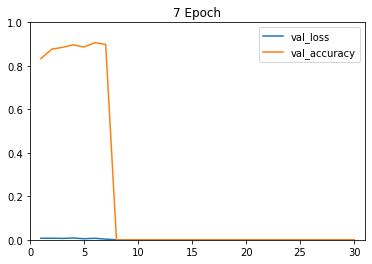

Train Epoch: 7 [0/5400 (0)%]\Loss 0.031315
Train Epoch: 7 [320/5400 (6)%]\Loss 0.213625
Train Epoch: 7 [640/5400 (12)%]\Loss 0.117011
Train Epoch: 7 [960/5400 (18)%]\Loss 0.017045
Train Epoch: 7 [1280/5400 (24)%]\Loss 0.012620
Train Epoch: 7 [1600/5400 (30)%]\Loss 0.023204
Train Epoch: 7 [1920/5400 (36)%]\Loss 0.042895
Train Epoch: 7 [2240/5400 (41)%]\Loss 0.124741
Train Epoch: 7 [2560/5400 (47)%]\Loss 0.020940
Train Epoch: 7 [2880/5400 (53)%]\Loss 0.027923
Train Epoch: 7 [3200/5400 (59)%]\Loss 0.073437
Train Epoch: 7 [3520/5400 (65)%]\Loss 0.242474
Train Epoch: 7 [3840/5400 (71)%]\Loss 0.058693
Train Epoch: 7 [4160/5400 (77)%]\Loss 0.067278
Train Epoch: 7 [4480/5400 (83)%]\Loss 0.048112
Train Epoch: 7 [4800/5400 (89)%]\Loss 0.171428
Train Epoch: 7 [5120/5400 (95)%]\Loss 0.051710
[7] Test Loss: 0.0107, Accuracy: 89.3333%


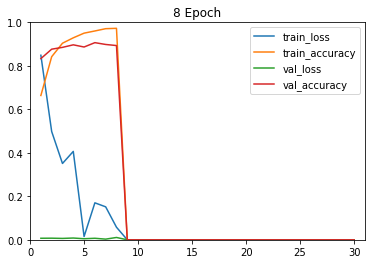

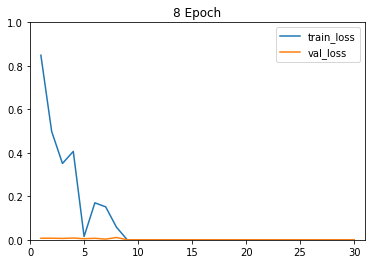

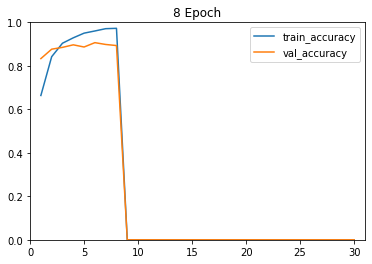

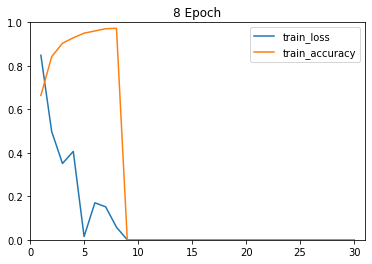

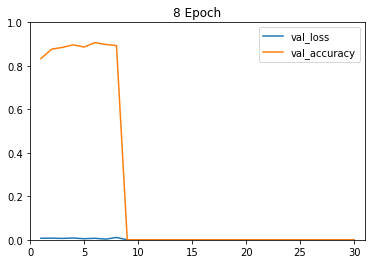

Train Epoch: 8 [0/5400 (0)%]\Loss 0.015881
Train Epoch: 8 [320/5400 (6)%]\Loss 0.034950
Train Epoch: 8 [640/5400 (12)%]\Loss 0.009781
Train Epoch: 8 [960/5400 (18)%]\Loss 0.026787
Train Epoch: 8 [1280/5400 (24)%]\Loss 0.038845
Train Epoch: 8 [1600/5400 (30)%]\Loss 0.046221
Train Epoch: 8 [1920/5400 (36)%]\Loss 0.046344
Train Epoch: 8 [2240/5400 (41)%]\Loss 0.010221
Train Epoch: 8 [2560/5400 (47)%]\Loss 0.095016
Train Epoch: 8 [2880/5400 (53)%]\Loss 0.038297
Train Epoch: 8 [3200/5400 (59)%]\Loss 0.103210
Train Epoch: 8 [3520/5400 (65)%]\Loss 0.235215
Train Epoch: 8 [3840/5400 (71)%]\Loss 0.069969
Train Epoch: 8 [4160/5400 (77)%]\Loss 0.098466
Train Epoch: 8 [4480/5400 (83)%]\Loss 0.073021
Train Epoch: 8 [4800/5400 (89)%]\Loss 0.358263
Train Epoch: 8 [5120/5400 (95)%]\Loss 0.057470
[8] Test Loss: 0.0158, Accuracy: 86.6667%


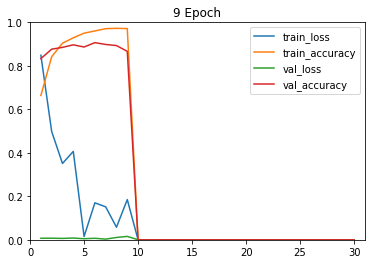

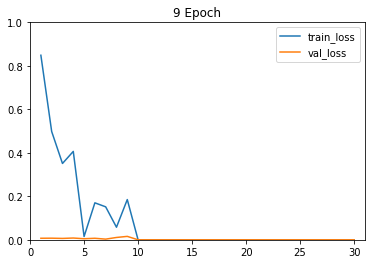

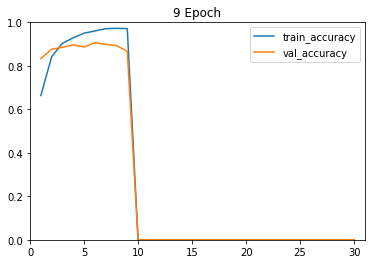

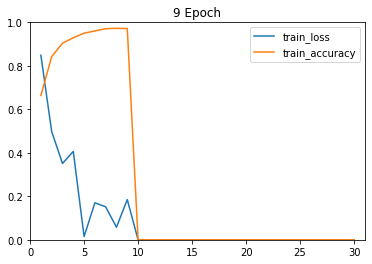

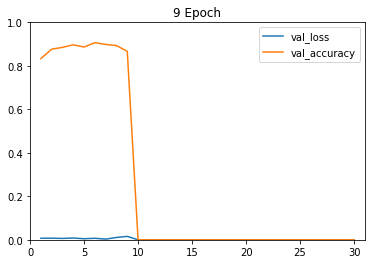

Train Epoch: 9 [0/5400 (0)%]\Loss 0.021963
Train Epoch: 9 [320/5400 (6)%]\Loss 0.134068
Train Epoch: 9 [640/5400 (12)%]\Loss 0.040524
Train Epoch: 9 [960/5400 (18)%]\Loss 0.042703
Train Epoch: 9 [1280/5400 (24)%]\Loss 0.171036
Train Epoch: 9 [1600/5400 (30)%]\Loss 0.225283
Train Epoch: 9 [1920/5400 (36)%]\Loss 0.033731
Train Epoch: 9 [2240/5400 (41)%]\Loss 0.075848
Train Epoch: 9 [2560/5400 (47)%]\Loss 0.064928
Train Epoch: 9 [2880/5400 (53)%]\Loss 0.118309
Train Epoch: 9 [3200/5400 (59)%]\Loss 0.018403
Train Epoch: 9 [3520/5400 (65)%]\Loss 0.022242
Train Epoch: 9 [3840/5400 (71)%]\Loss 0.118848
Train Epoch: 9 [4160/5400 (77)%]\Loss 0.126546
Train Epoch: 9 [4480/5400 (83)%]\Loss 0.173304
Train Epoch: 9 [4800/5400 (89)%]\Loss 0.092429
Train Epoch: 9 [5120/5400 (95)%]\Loss 0.061670
[9] Test Loss: 0.0057, Accuracy: 90.8333%


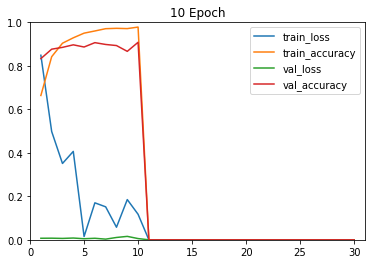

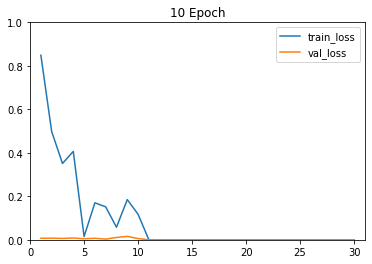

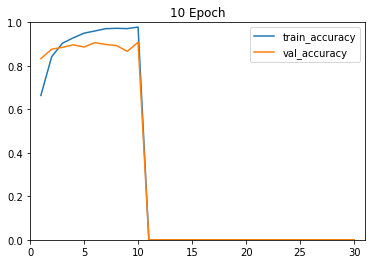

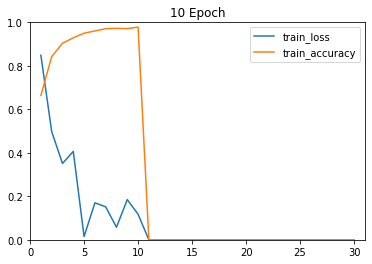

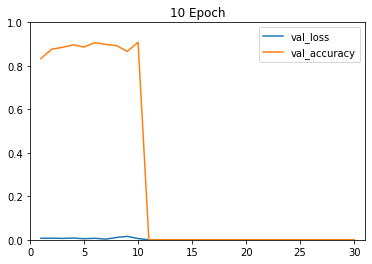

Train Epoch: 10 [0/5400 (0)%]\Loss 0.011364
Train Epoch: 10 [320/5400 (6)%]\Loss 0.057453
Train Epoch: 10 [640/5400 (12)%]\Loss 0.048213
Train Epoch: 10 [960/5400 (18)%]\Loss 0.173916
Train Epoch: 10 [1280/5400 (24)%]\Loss 0.016338
Train Epoch: 10 [1600/5400 (30)%]\Loss 0.045499
Train Epoch: 10 [1920/5400 (36)%]\Loss 0.048101
Train Epoch: 10 [2240/5400 (41)%]\Loss 0.051688
Train Epoch: 10 [2560/5400 (47)%]\Loss 0.039823
Train Epoch: 10 [2880/5400 (53)%]\Loss 0.016877
Train Epoch: 10 [3200/5400 (59)%]\Loss 0.012718
Train Epoch: 10 [3520/5400 (65)%]\Loss 0.042563
Train Epoch: 10 [3840/5400 (71)%]\Loss 0.132575
Train Epoch: 10 [4160/5400 (77)%]\Loss 0.016618
Train Epoch: 10 [4480/5400 (83)%]\Loss 0.063726
Train Epoch: 10 [4800/5400 (89)%]\Loss 0.033917
Train Epoch: 10 [5120/5400 (95)%]\Loss 0.014250
[10] Test Loss: 0.0034, Accuracy: 92.1667%


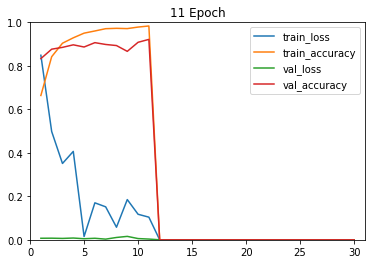

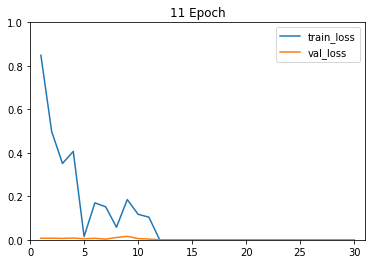

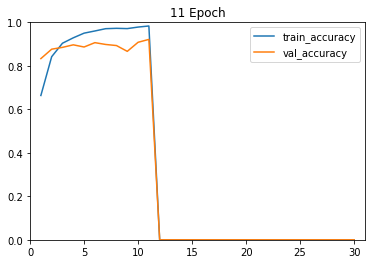

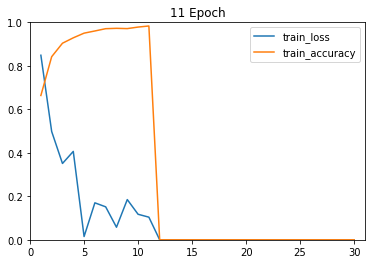

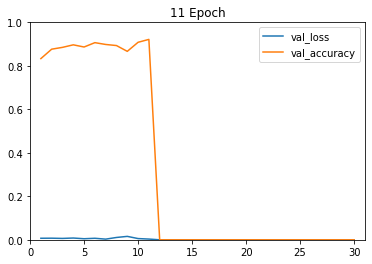

Train Epoch: 11 [0/5400 (0)%]\Loss 0.018340
Train Epoch: 11 [320/5400 (6)%]\Loss 0.036992
Train Epoch: 11 [640/5400 (12)%]\Loss 0.005676
Train Epoch: 11 [960/5400 (18)%]\Loss 0.046645
Train Epoch: 11 [1280/5400 (24)%]\Loss 0.028055
Train Epoch: 11 [1600/5400 (30)%]\Loss 0.024597
Train Epoch: 11 [1920/5400 (36)%]\Loss 0.112896
Train Epoch: 11 [2240/5400 (41)%]\Loss 0.005726
Train Epoch: 11 [2560/5400 (47)%]\Loss 0.019518
Train Epoch: 11 [2880/5400 (53)%]\Loss 0.023332
Train Epoch: 11 [3200/5400 (59)%]\Loss 0.110098
Train Epoch: 11 [3520/5400 (65)%]\Loss 0.017449
Train Epoch: 11 [3840/5400 (71)%]\Loss 0.053899
Train Epoch: 11 [4160/5400 (77)%]\Loss 0.007769
Train Epoch: 11 [4480/5400 (83)%]\Loss 0.016080
Train Epoch: 11 [4800/5400 (89)%]\Loss 0.006658
Train Epoch: 11 [5120/5400 (95)%]\Loss 0.022542
[11] Test Loss: 0.0052, Accuracy: 91.5000%


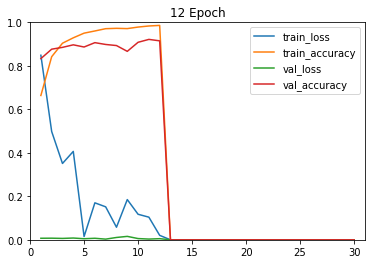

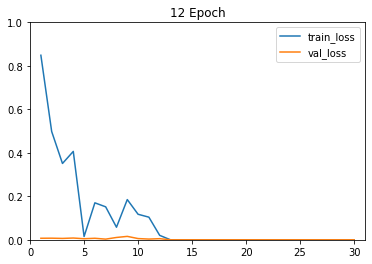

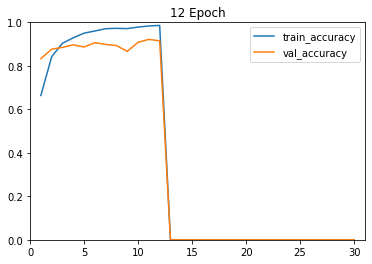

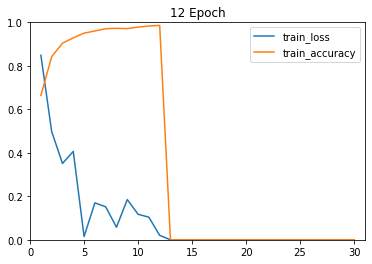

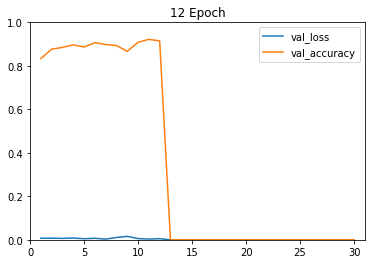

Train Epoch: 12 [0/5400 (0)%]\Loss 0.062979
Train Epoch: 12 [320/5400 (6)%]\Loss 0.013014
Train Epoch: 12 [640/5400 (12)%]\Loss 0.158464
Train Epoch: 12 [960/5400 (18)%]\Loss 0.023305
Train Epoch: 12 [1280/5400 (24)%]\Loss 0.016273
Train Epoch: 12 [1600/5400 (30)%]\Loss 0.007823
Train Epoch: 12 [1920/5400 (36)%]\Loss 0.009417
Train Epoch: 12 [2240/5400 (41)%]\Loss 0.122977
Train Epoch: 12 [2560/5400 (47)%]\Loss 0.015702
Train Epoch: 12 [2880/5400 (53)%]\Loss 0.015653
Train Epoch: 12 [3200/5400 (59)%]\Loss 0.047354
Train Epoch: 12 [3520/5400 (65)%]\Loss 0.028548
Train Epoch: 12 [3840/5400 (71)%]\Loss 0.014952
Train Epoch: 12 [4160/5400 (77)%]\Loss 0.134905
Train Epoch: 12 [4480/5400 (83)%]\Loss 0.008240
Train Epoch: 12 [4800/5400 (89)%]\Loss 0.089479
Train Epoch: 12 [5120/5400 (95)%]\Loss 0.087992
[12] Test Loss: 0.0057, Accuracy: 91.5000%


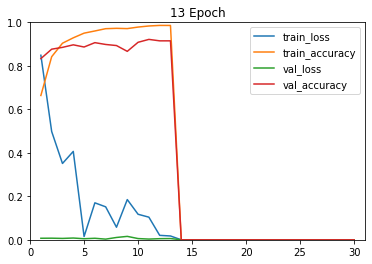

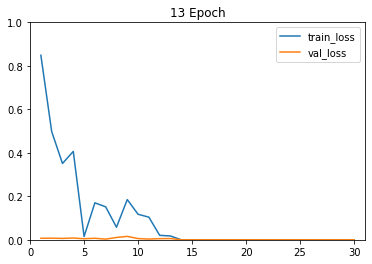

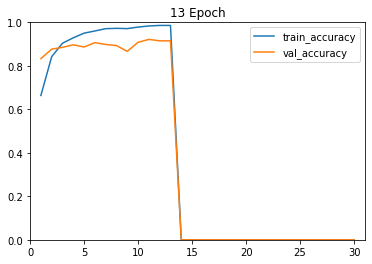

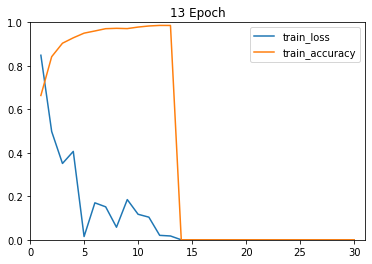

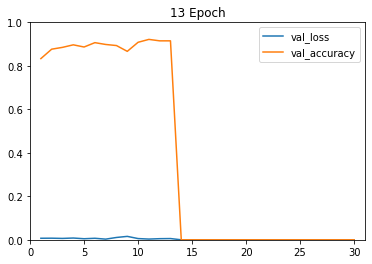

Train Epoch: 13 [0/5400 (0)%]\Loss 0.017922
Train Epoch: 13 [320/5400 (6)%]\Loss 0.100192
Train Epoch: 13 [640/5400 (12)%]\Loss 0.016858
Train Epoch: 13 [960/5400 (18)%]\Loss 0.028933
Train Epoch: 13 [1280/5400 (24)%]\Loss 0.007924
Train Epoch: 13 [1600/5400 (30)%]\Loss 0.005868
Train Epoch: 13 [1920/5400 (36)%]\Loss 0.203085
Train Epoch: 13 [2240/5400 (41)%]\Loss 0.025032
Train Epoch: 13 [2560/5400 (47)%]\Loss 0.020686
Train Epoch: 13 [2880/5400 (53)%]\Loss 0.029522
Train Epoch: 13 [3200/5400 (59)%]\Loss 0.265719
Train Epoch: 13 [3520/5400 (65)%]\Loss 0.010925
Train Epoch: 13 [3840/5400 (71)%]\Loss 0.070592
Train Epoch: 13 [4160/5400 (77)%]\Loss 0.008844
Train Epoch: 13 [4480/5400 (83)%]\Loss 0.009537
Train Epoch: 13 [4800/5400 (89)%]\Loss 0.041281
Train Epoch: 13 [5120/5400 (95)%]\Loss 0.043854
[13] Test Loss: 0.0041, Accuracy: 91.8333%


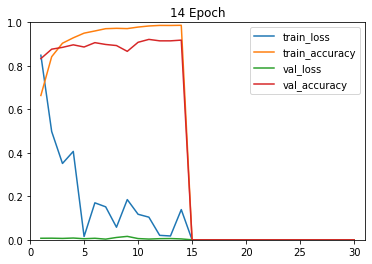

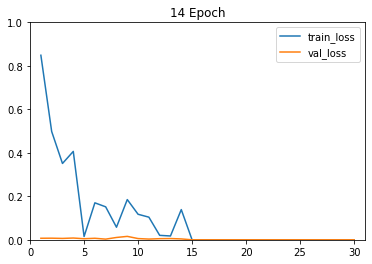

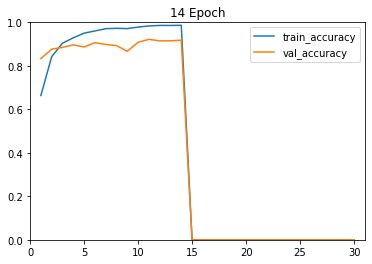

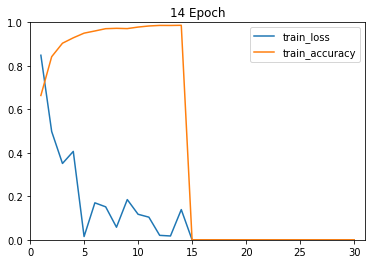

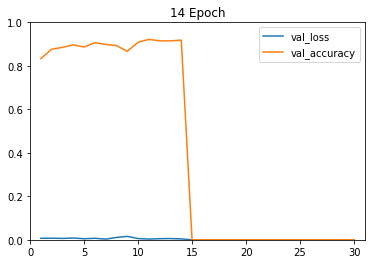

Train Epoch: 14 [0/5400 (0)%]\Loss 0.103240
Train Epoch: 14 [320/5400 (6)%]\Loss 0.102474
Train Epoch: 14 [640/5400 (12)%]\Loss 0.012993
Train Epoch: 14 [960/5400 (18)%]\Loss 0.010752
Train Epoch: 14 [1280/5400 (24)%]\Loss 0.007752
Train Epoch: 14 [1600/5400 (30)%]\Loss 0.017918
Train Epoch: 14 [1920/5400 (36)%]\Loss 0.030060
Train Epoch: 14 [2240/5400 (41)%]\Loss 0.068346
Train Epoch: 14 [2560/5400 (47)%]\Loss 0.049414
Train Epoch: 14 [2880/5400 (53)%]\Loss 0.015655
Train Epoch: 14 [3200/5400 (59)%]\Loss 0.067429
Train Epoch: 14 [3520/5400 (65)%]\Loss 0.160147
Train Epoch: 14 [3840/5400 (71)%]\Loss 0.049141
Train Epoch: 14 [4160/5400 (77)%]\Loss 0.014694
Train Epoch: 14 [4480/5400 (83)%]\Loss 0.080854
Train Epoch: 14 [4800/5400 (89)%]\Loss 0.017995
Train Epoch: 14 [5120/5400 (95)%]\Loss 0.006580
[14] Test Loss: 0.0030, Accuracy: 92.1667%


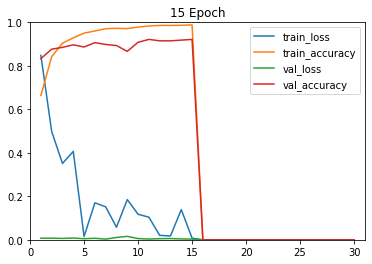

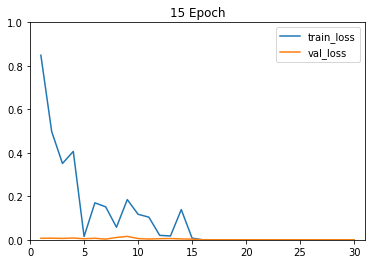

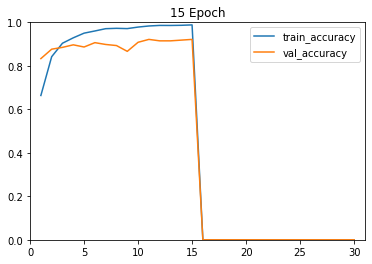

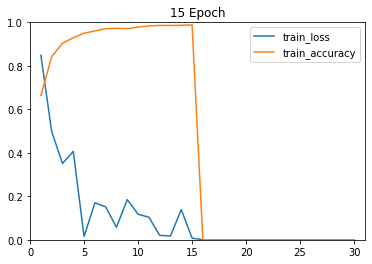

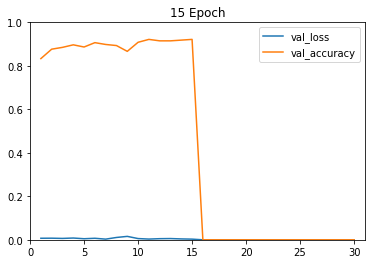

Train Epoch: 15 [0/5400 (0)%]\Loss 0.047767
Train Epoch: 15 [320/5400 (6)%]\Loss 0.046170
Train Epoch: 15 [640/5400 (12)%]\Loss 0.009416
Train Epoch: 15 [960/5400 (18)%]\Loss 0.137761
Train Epoch: 15 [1280/5400 (24)%]\Loss 0.006117
Train Epoch: 15 [1600/5400 (30)%]\Loss 0.109380
Train Epoch: 15 [1920/5400 (36)%]\Loss 0.010909
Train Epoch: 15 [2240/5400 (41)%]\Loss 0.016644
Train Epoch: 15 [2560/5400 (47)%]\Loss 0.124268
Train Epoch: 15 [2880/5400 (53)%]\Loss 0.010304
Train Epoch: 15 [3200/5400 (59)%]\Loss 0.079760
Train Epoch: 15 [3520/5400 (65)%]\Loss 0.004953
Train Epoch: 15 [3840/5400 (71)%]\Loss 0.005327
Train Epoch: 15 [4160/5400 (77)%]\Loss 0.011629
Train Epoch: 15 [4480/5400 (83)%]\Loss 0.007719
Train Epoch: 15 [4800/5400 (89)%]\Loss 0.009963
Train Epoch: 15 [5120/5400 (95)%]\Loss 0.023609
[15] Test Loss: 0.0051, Accuracy: 91.3333%


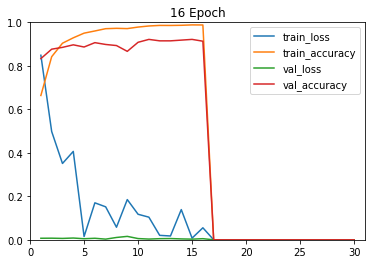

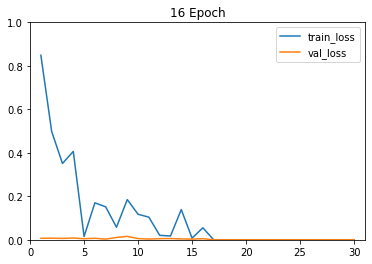

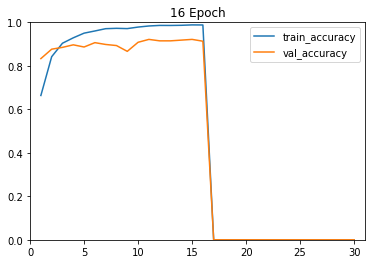

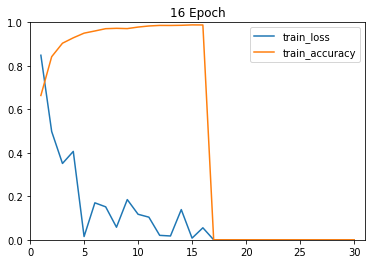

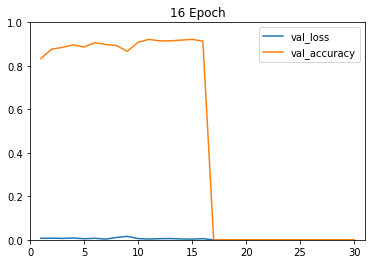

Train Epoch: 16 [0/5400 (0)%]\Loss 0.030072
Train Epoch: 16 [320/5400 (6)%]\Loss 0.017560
Train Epoch: 16 [640/5400 (12)%]\Loss 0.029743
Train Epoch: 16 [960/5400 (18)%]\Loss 0.064619
Train Epoch: 16 [1280/5400 (24)%]\Loss 0.019169
Train Epoch: 16 [1600/5400 (30)%]\Loss 0.019133
Train Epoch: 16 [1920/5400 (36)%]\Loss 0.178138
Train Epoch: 16 [2240/5400 (41)%]\Loss 0.007992
Train Epoch: 16 [2560/5400 (47)%]\Loss 0.012321
Train Epoch: 16 [2880/5400 (53)%]\Loss 0.081201
Train Epoch: 16 [3200/5400 (59)%]\Loss 0.019689
Train Epoch: 16 [3520/5400 (65)%]\Loss 0.041377
Train Epoch: 16 [3840/5400 (71)%]\Loss 0.041190
Train Epoch: 16 [4160/5400 (77)%]\Loss 0.014619
Train Epoch: 16 [4480/5400 (83)%]\Loss 0.007274
Train Epoch: 16 [4800/5400 (89)%]\Loss 0.063308
Train Epoch: 16 [5120/5400 (95)%]\Loss 0.044162
[16] Test Loss: 0.0037, Accuracy: 92.0000%


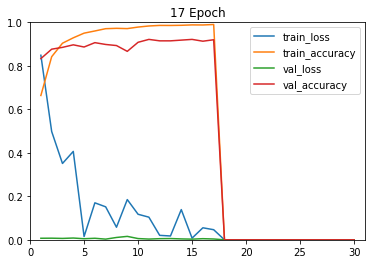

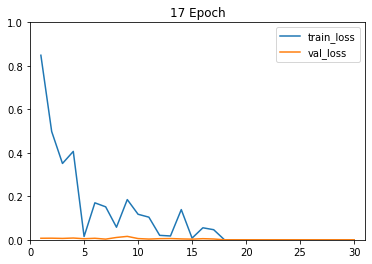

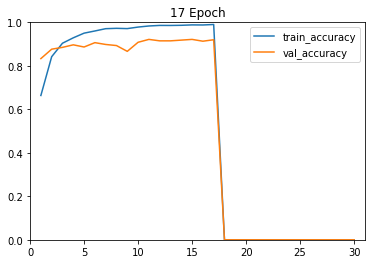

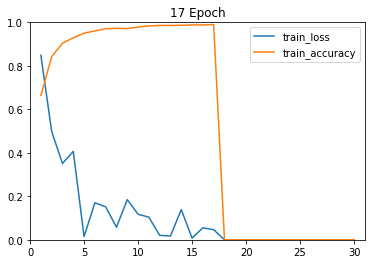

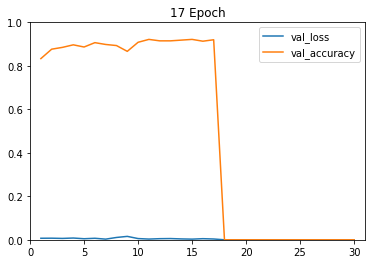

Train Epoch: 17 [0/5400 (0)%]\Loss 0.026765
Train Epoch: 17 [320/5400 (6)%]\Loss 0.025958
Train Epoch: 17 [640/5400 (12)%]\Loss 0.035478
Train Epoch: 17 [960/5400 (18)%]\Loss 0.011061
Train Epoch: 17 [1280/5400 (24)%]\Loss 0.006609
Train Epoch: 17 [1600/5400 (30)%]\Loss 0.005766
Train Epoch: 17 [1920/5400 (36)%]\Loss 0.062546
Train Epoch: 17 [2240/5400 (41)%]\Loss 0.028806
Train Epoch: 17 [2560/5400 (47)%]\Loss 0.013523
Train Epoch: 17 [2880/5400 (53)%]\Loss 0.001936
Train Epoch: 17 [3200/5400 (59)%]\Loss 0.035732
Train Epoch: 17 [3520/5400 (65)%]\Loss 0.057397
Train Epoch: 17 [3840/5400 (71)%]\Loss 0.071205
Train Epoch: 17 [4160/5400 (77)%]\Loss 0.048338
Train Epoch: 17 [4480/5400 (83)%]\Loss 0.014570
Train Epoch: 17 [4800/5400 (89)%]\Loss 0.013601
Train Epoch: 17 [5120/5400 (95)%]\Loss 0.017329
[17] Test Loss: 0.0043, Accuracy: 91.5000%


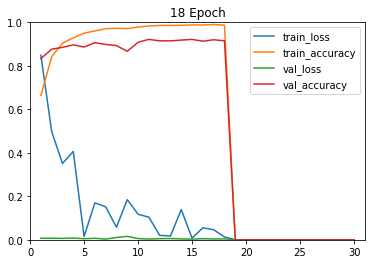

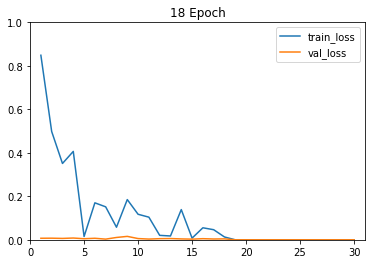

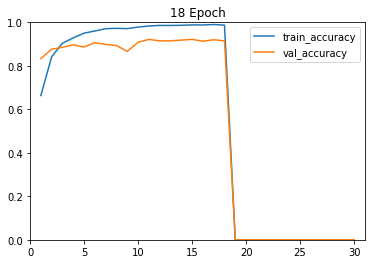

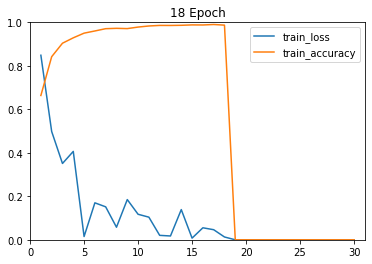

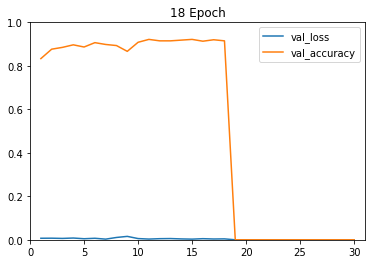

Train Epoch: 18 [0/5400 (0)%]\Loss 0.005184
Train Epoch: 18 [320/5400 (6)%]\Loss 0.035599
Train Epoch: 18 [640/5400 (12)%]\Loss 0.007009
Train Epoch: 18 [960/5400 (18)%]\Loss 0.021027
Train Epoch: 18 [1280/5400 (24)%]\Loss 0.011095
Train Epoch: 18 [1600/5400 (30)%]\Loss 0.033164
Train Epoch: 18 [1920/5400 (36)%]\Loss 0.076362
Train Epoch: 18 [2240/5400 (41)%]\Loss 0.035296
Train Epoch: 18 [2560/5400 (47)%]\Loss 0.004695
Train Epoch: 18 [2880/5400 (53)%]\Loss 0.017127
Train Epoch: 18 [3200/5400 (59)%]\Loss 0.015053
Train Epoch: 18 [3520/5400 (65)%]\Loss 0.042453
Train Epoch: 18 [3840/5400 (71)%]\Loss 0.190240
Train Epoch: 18 [4160/5400 (77)%]\Loss 0.086230
Train Epoch: 18 [4480/5400 (83)%]\Loss 0.032413
Train Epoch: 18 [4800/5400 (89)%]\Loss 0.032242
Train Epoch: 18 [5120/5400 (95)%]\Loss 0.052483
[18] Test Loss: 0.0051, Accuracy: 90.8333%


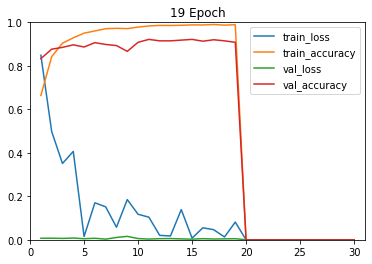

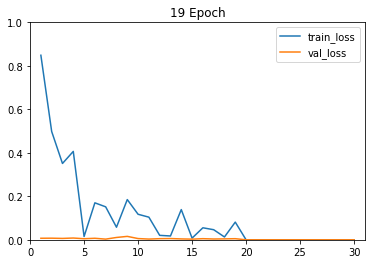

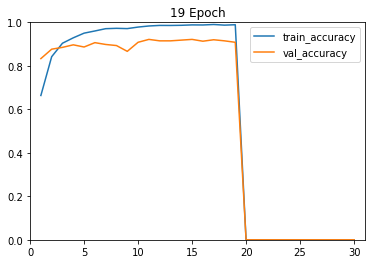

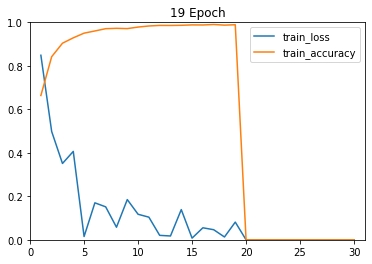

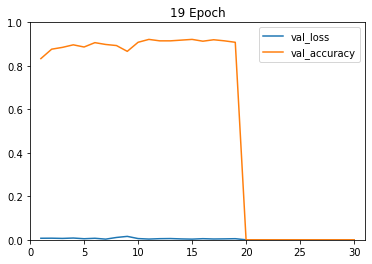

Train Epoch: 19 [0/5400 (0)%]\Loss 0.021022
Train Epoch: 19 [320/5400 (6)%]\Loss 0.048750
Train Epoch: 19 [640/5400 (12)%]\Loss 0.052277
Train Epoch: 19 [960/5400 (18)%]\Loss 0.035382
Train Epoch: 19 [1280/5400 (24)%]\Loss 0.033289
Train Epoch: 19 [1600/5400 (30)%]\Loss 0.011308
Train Epoch: 19 [1920/5400 (36)%]\Loss 0.040858
Train Epoch: 19 [2240/5400 (41)%]\Loss 0.012022
Train Epoch: 19 [2560/5400 (47)%]\Loss 0.029505
Train Epoch: 19 [2880/5400 (53)%]\Loss 0.153492
Train Epoch: 19 [3200/5400 (59)%]\Loss 0.023799
Train Epoch: 19 [3520/5400 (65)%]\Loss 0.019501
Train Epoch: 19 [3840/5400 (71)%]\Loss 0.033449
Train Epoch: 19 [4160/5400 (77)%]\Loss 0.080782
Train Epoch: 19 [4480/5400 (83)%]\Loss 0.024132
Train Epoch: 19 [4800/5400 (89)%]\Loss 0.030561
Train Epoch: 19 [5120/5400 (95)%]\Loss 0.007313
[19] Test Loss: 0.0029, Accuracy: 92.1667%


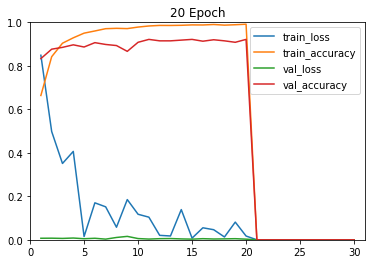

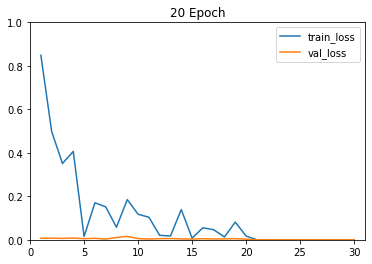

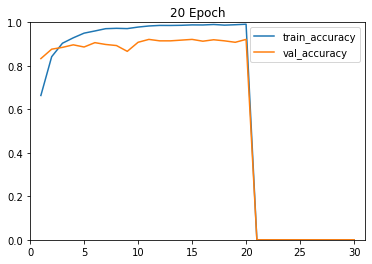

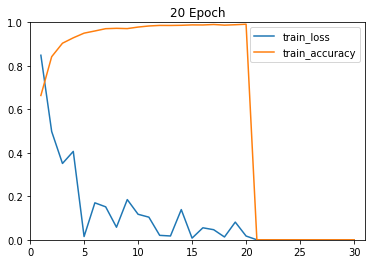

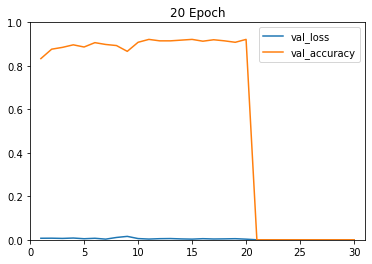

Train Epoch: 20 [0/5400 (0)%]\Loss 0.015707
Train Epoch: 20 [320/5400 (6)%]\Loss 0.056073
Train Epoch: 20 [640/5400 (12)%]\Loss 0.012152
Train Epoch: 20 [960/5400 (18)%]\Loss 0.006280
Train Epoch: 20 [1280/5400 (24)%]\Loss 0.040985
Train Epoch: 20 [1600/5400 (30)%]\Loss 0.010533
Train Epoch: 20 [1920/5400 (36)%]\Loss 0.011073
Train Epoch: 20 [2240/5400 (41)%]\Loss 0.023362
Train Epoch: 20 [2560/5400 (47)%]\Loss 0.040869
Train Epoch: 20 [2880/5400 (53)%]\Loss 0.113052
Train Epoch: 20 [3200/5400 (59)%]\Loss 0.005449
Train Epoch: 20 [3520/5400 (65)%]\Loss 0.009828
Train Epoch: 20 [3840/5400 (71)%]\Loss 0.025135
Train Epoch: 20 [4160/5400 (77)%]\Loss 0.013463
Train Epoch: 20 [4480/5400 (83)%]\Loss 0.008309
Train Epoch: 20 [4800/5400 (89)%]\Loss 0.010643
Train Epoch: 20 [5120/5400 (95)%]\Loss 0.051884
[20] Test Loss: 0.0034, Accuracy: 91.8333%


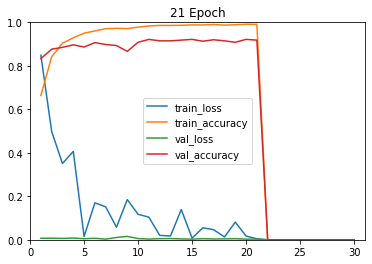

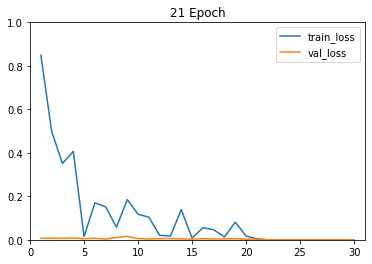

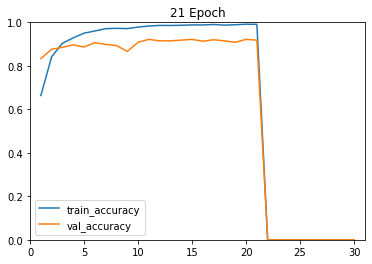

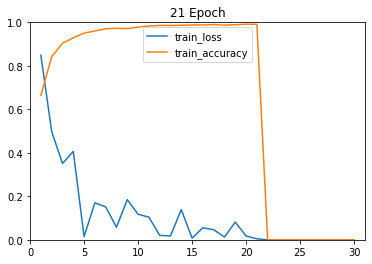

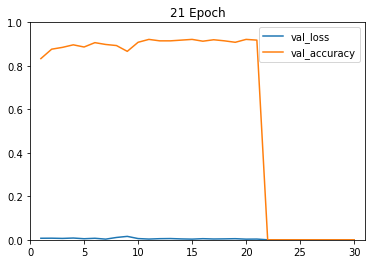

Train Epoch: 21 [0/5400 (0)%]\Loss 0.010255
Train Epoch: 21 [320/5400 (6)%]\Loss 0.004483
Train Epoch: 21 [640/5400 (12)%]\Loss 0.028056
Train Epoch: 21 [960/5400 (18)%]\Loss 0.093068
Train Epoch: 21 [1280/5400 (24)%]\Loss 0.043522
Train Epoch: 21 [1600/5400 (30)%]\Loss 0.012966
Train Epoch: 21 [1920/5400 (36)%]\Loss 0.087572
Train Epoch: 21 [2240/5400 (41)%]\Loss 0.016963
Train Epoch: 21 [2560/5400 (47)%]\Loss 0.016806
Train Epoch: 21 [2880/5400 (53)%]\Loss 0.012677
Train Epoch: 21 [3200/5400 (59)%]\Loss 0.012881
Train Epoch: 21 [3520/5400 (65)%]\Loss 0.120885
Train Epoch: 21 [3840/5400 (71)%]\Loss 0.014052
Train Epoch: 21 [4160/5400 (77)%]\Loss 0.064062
Train Epoch: 21 [4480/5400 (83)%]\Loss 0.008418
Train Epoch: 21 [4800/5400 (89)%]\Loss 0.113587
Train Epoch: 21 [5120/5400 (95)%]\Loss 0.011292
[21] Test Loss: 0.0042, Accuracy: 91.6667%


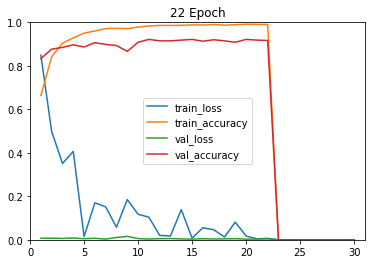

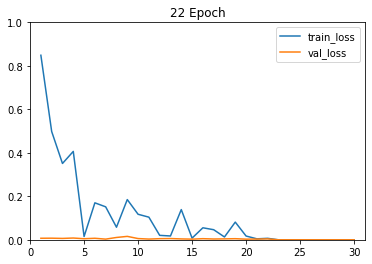

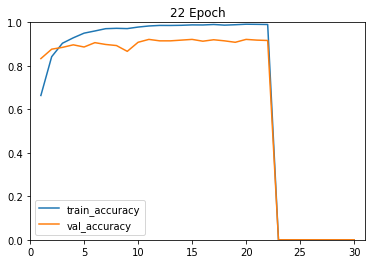

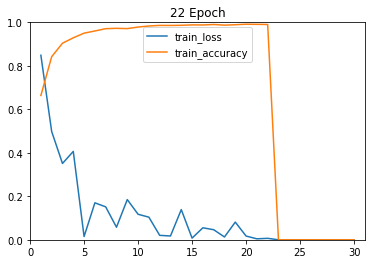

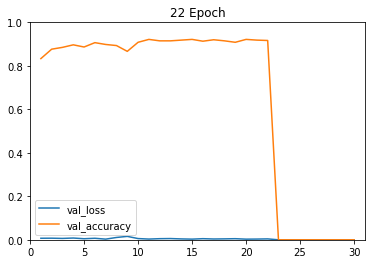

Train Epoch: 22 [0/5400 (0)%]\Loss 0.016304
Train Epoch: 22 [320/5400 (6)%]\Loss 0.017710
Train Epoch: 22 [640/5400 (12)%]\Loss 0.092341
Train Epoch: 22 [960/5400 (18)%]\Loss 0.012553
Train Epoch: 22 [1280/5400 (24)%]\Loss 0.018608
Train Epoch: 22 [1600/5400 (30)%]\Loss 0.029862
Train Epoch: 22 [1920/5400 (36)%]\Loss 0.017293
Train Epoch: 22 [2240/5400 (41)%]\Loss 0.025707
Train Epoch: 22 [2560/5400 (47)%]\Loss 0.031385
Train Epoch: 22 [2880/5400 (53)%]\Loss 0.083526
Train Epoch: 22 [3200/5400 (59)%]\Loss 0.069019
Train Epoch: 22 [3520/5400 (65)%]\Loss 0.009345
Train Epoch: 22 [3840/5400 (71)%]\Loss 0.003644
Train Epoch: 22 [4160/5400 (77)%]\Loss 0.071997
Train Epoch: 22 [4480/5400 (83)%]\Loss 0.006168
Train Epoch: 22 [4800/5400 (89)%]\Loss 0.015613
Train Epoch: 22 [5120/5400 (95)%]\Loss 0.026574
[22] Test Loss: 0.0045, Accuracy: 92.1667%


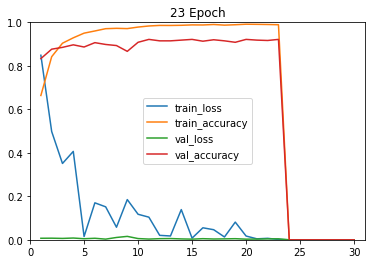

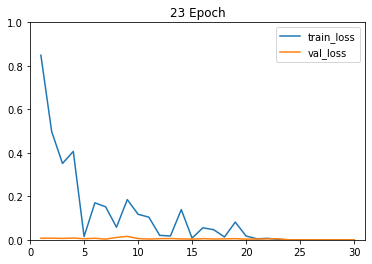

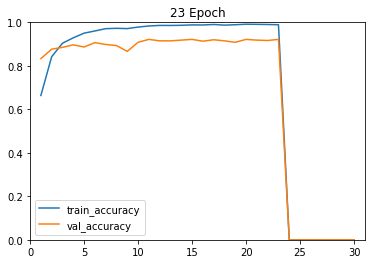

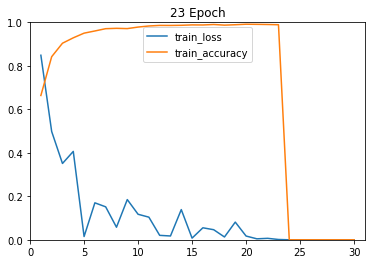

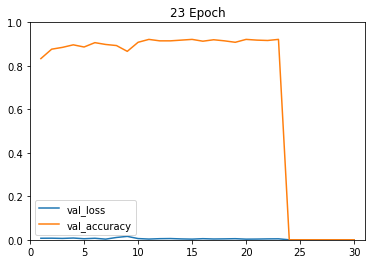

Train Epoch: 23 [0/5400 (0)%]\Loss 0.030661
Train Epoch: 23 [320/5400 (6)%]\Loss 0.107644
Train Epoch: 23 [640/5400 (12)%]\Loss 0.009710
Train Epoch: 23 [960/5400 (18)%]\Loss 0.004073
Train Epoch: 23 [1280/5400 (24)%]\Loss 0.019810
Train Epoch: 23 [1600/5400 (30)%]\Loss 0.026096
Train Epoch: 23 [1920/5400 (36)%]\Loss 0.012110
Train Epoch: 23 [2240/5400 (41)%]\Loss 0.020433
Train Epoch: 23 [2560/5400 (47)%]\Loss 0.042967
Train Epoch: 23 [2880/5400 (53)%]\Loss 0.051982
Train Epoch: 23 [3200/5400 (59)%]\Loss 0.032509
Train Epoch: 23 [3520/5400 (65)%]\Loss 0.139634
Train Epoch: 23 [3840/5400 (71)%]\Loss 0.033687
Train Epoch: 23 [4160/5400 (77)%]\Loss 0.034835
Train Epoch: 23 [4480/5400 (83)%]\Loss 0.012852
Train Epoch: 23 [4800/5400 (89)%]\Loss 0.023758
Train Epoch: 23 [5120/5400 (95)%]\Loss 0.006641
[23] Test Loss: 0.0030, Accuracy: 92.1667%


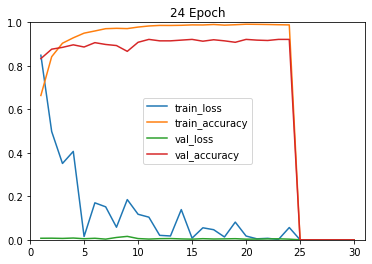

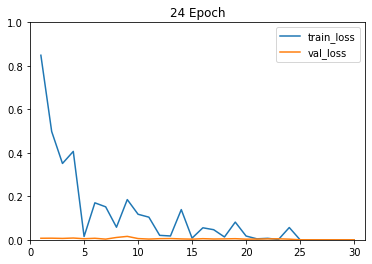

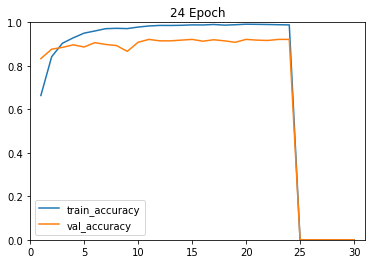

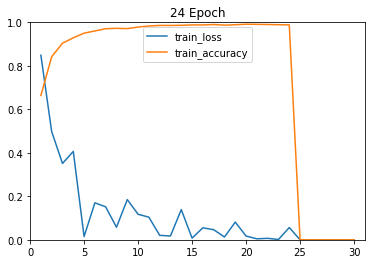

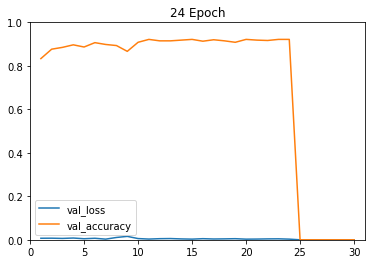

Train Epoch: 24 [0/5400 (0)%]\Loss 0.024314
Train Epoch: 24 [320/5400 (6)%]\Loss 0.026591
Train Epoch: 24 [640/5400 (12)%]\Loss 0.008948
Train Epoch: 24 [960/5400 (18)%]\Loss 0.041741
Train Epoch: 24 [1280/5400 (24)%]\Loss 0.021174
Train Epoch: 24 [1600/5400 (30)%]\Loss 0.009743
Train Epoch: 24 [1920/5400 (36)%]\Loss 0.082203
Train Epoch: 24 [2240/5400 (41)%]\Loss 0.009008
Train Epoch: 24 [2560/5400 (47)%]\Loss 0.008189
Train Epoch: 24 [2880/5400 (53)%]\Loss 0.022789
Train Epoch: 24 [3200/5400 (59)%]\Loss 0.076957
Train Epoch: 24 [3520/5400 (65)%]\Loss 0.021856
Train Epoch: 24 [3840/5400 (71)%]\Loss 0.108673
Train Epoch: 24 [4160/5400 (77)%]\Loss 0.009390
Train Epoch: 24 [4480/5400 (83)%]\Loss 0.015049
Train Epoch: 24 [4800/5400 (89)%]\Loss 0.055643
Train Epoch: 24 [5120/5400 (95)%]\Loss 0.002693
[24] Test Loss: 0.0044, Accuracy: 92.1667%


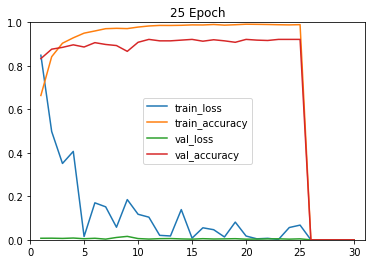

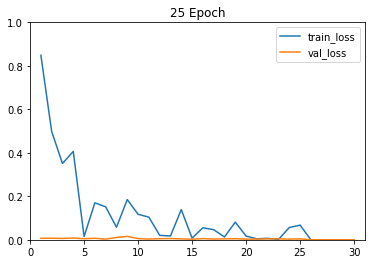

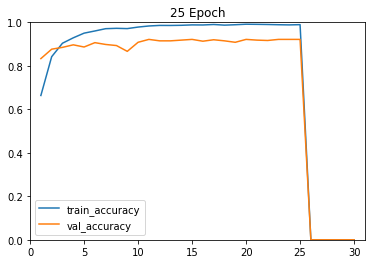

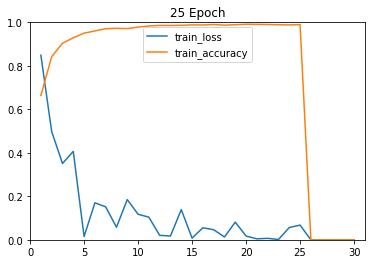

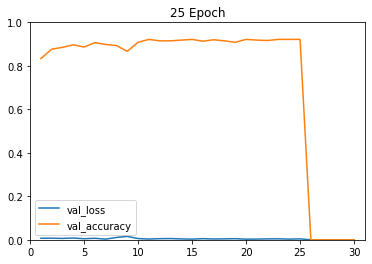

Train Epoch: 25 [0/5400 (0)%]\Loss 0.033103
Train Epoch: 25 [320/5400 (6)%]\Loss 0.020750
Train Epoch: 25 [640/5400 (12)%]\Loss 0.035594
Train Epoch: 25 [960/5400 (18)%]\Loss 0.025163
Train Epoch: 25 [1280/5400 (24)%]\Loss 0.034940
Train Epoch: 25 [1600/5400 (30)%]\Loss 0.026566
Train Epoch: 25 [1920/5400 (36)%]\Loss 0.023800
Train Epoch: 25 [2240/5400 (41)%]\Loss 0.016420
Train Epoch: 25 [2560/5400 (47)%]\Loss 0.024082
Train Epoch: 25 [2880/5400 (53)%]\Loss 0.016136
Train Epoch: 25 [3200/5400 (59)%]\Loss 0.063838
Train Epoch: 25 [3520/5400 (65)%]\Loss 0.070846
Train Epoch: 25 [3840/5400 (71)%]\Loss 0.057649
Train Epoch: 25 [4160/5400 (77)%]\Loss 0.006633
Train Epoch: 25 [4480/5400 (83)%]\Loss 0.010355
Train Epoch: 25 [4800/5400 (89)%]\Loss 0.010913
Train Epoch: 25 [5120/5400 (95)%]\Loss 0.054466
[25] Test Loss: 0.0028, Accuracy: 92.6667%


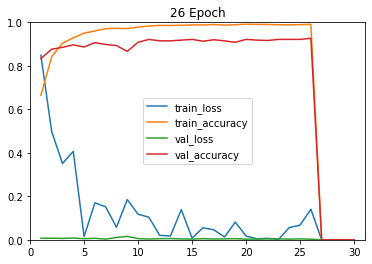

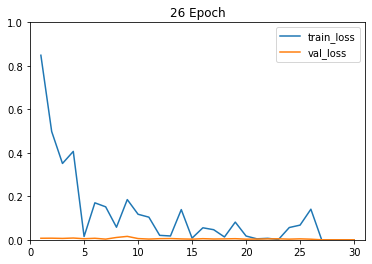

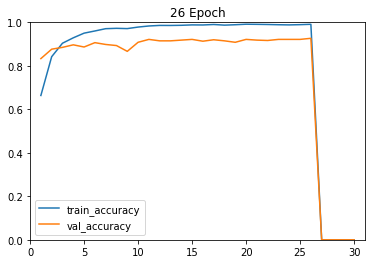

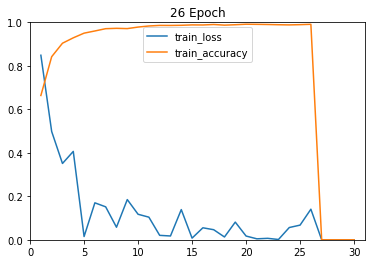

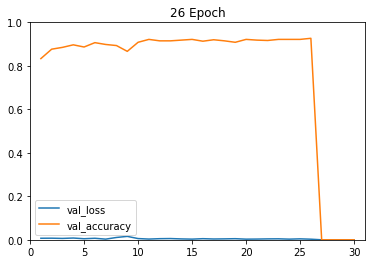

Train Epoch: 26 [0/5400 (0)%]\Loss 0.024840
Train Epoch: 26 [320/5400 (6)%]\Loss 0.074897
Train Epoch: 26 [640/5400 (12)%]\Loss 0.012269
Train Epoch: 26 [960/5400 (18)%]\Loss 0.035186
Train Epoch: 26 [1280/5400 (24)%]\Loss 0.033620
Train Epoch: 26 [1600/5400 (30)%]\Loss 0.014283
Train Epoch: 26 [1920/5400 (36)%]\Loss 0.043761
Train Epoch: 26 [2240/5400 (41)%]\Loss 0.010959
Train Epoch: 26 [2560/5400 (47)%]\Loss 0.029622
Train Epoch: 26 [2880/5400 (53)%]\Loss 0.016433
Train Epoch: 26 [3200/5400 (59)%]\Loss 0.012096
Train Epoch: 26 [3520/5400 (65)%]\Loss 0.210002
Train Epoch: 26 [3840/5400 (71)%]\Loss 0.004282
Train Epoch: 26 [4160/5400 (77)%]\Loss 0.063403
Train Epoch: 26 [4480/5400 (83)%]\Loss 0.032537
Train Epoch: 26 [4800/5400 (89)%]\Loss 0.005894
Train Epoch: 26 [5120/5400 (95)%]\Loss 0.025819
[26] Test Loss: 0.0033, Accuracy: 92.1667%


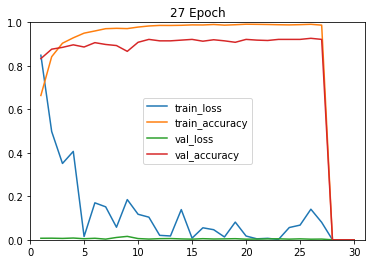

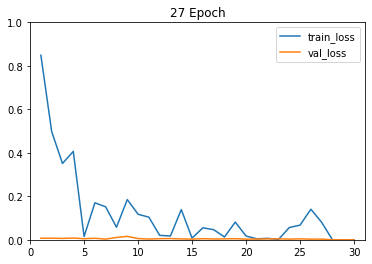

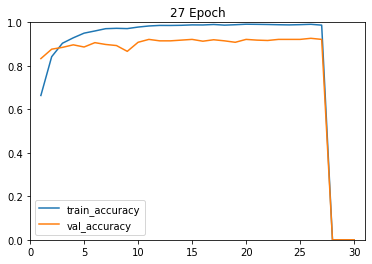

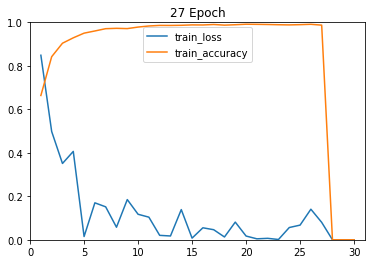

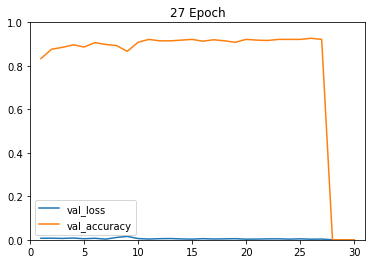

Train Epoch: 27 [0/5400 (0)%]\Loss 0.049395
Train Epoch: 27 [320/5400 (6)%]\Loss 0.018803
Train Epoch: 27 [640/5400 (12)%]\Loss 0.013473
Train Epoch: 27 [960/5400 (18)%]\Loss 0.046644
Train Epoch: 27 [1280/5400 (24)%]\Loss 0.083313
Train Epoch: 27 [1600/5400 (30)%]\Loss 0.017732
Train Epoch: 27 [1920/5400 (36)%]\Loss 0.006517
Train Epoch: 27 [2240/5400 (41)%]\Loss 0.014245
Train Epoch: 27 [2560/5400 (47)%]\Loss 0.007596
Train Epoch: 27 [2880/5400 (53)%]\Loss 0.009359
Train Epoch: 27 [3200/5400 (59)%]\Loss 0.058083
Train Epoch: 27 [3520/5400 (65)%]\Loss 0.036644
Train Epoch: 27 [3840/5400 (71)%]\Loss 0.005982
Train Epoch: 27 [4160/5400 (77)%]\Loss 0.052433
Train Epoch: 27 [4480/5400 (83)%]\Loss 0.052468
Train Epoch: 27 [4800/5400 (89)%]\Loss 0.028082
Train Epoch: 27 [5120/5400 (95)%]\Loss 0.045546
[27] Test Loss: 0.0038, Accuracy: 91.8333%


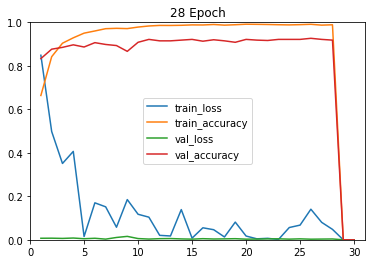

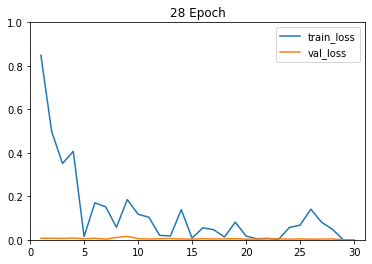

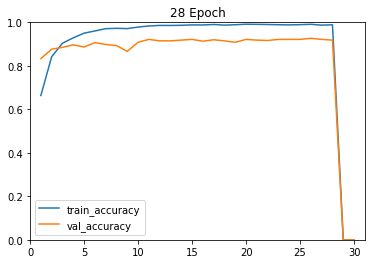

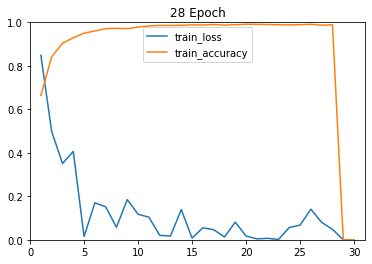

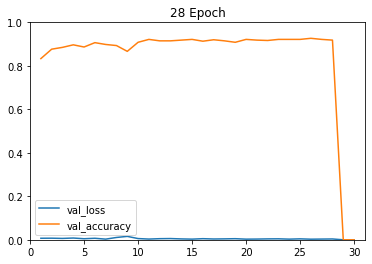

Train Epoch: 28 [0/5400 (0)%]\Loss 0.101089
Train Epoch: 28 [320/5400 (6)%]\Loss 0.010438
Train Epoch: 28 [640/5400 (12)%]\Loss 0.023242
Train Epoch: 28 [960/5400 (18)%]\Loss 0.027470
Train Epoch: 28 [1280/5400 (24)%]\Loss 0.028444
Train Epoch: 28 [1600/5400 (30)%]\Loss 0.066041
Train Epoch: 28 [1920/5400 (36)%]\Loss 0.062631
Train Epoch: 28 [2240/5400 (41)%]\Loss 0.038657
Train Epoch: 28 [2560/5400 (47)%]\Loss 0.130533
Train Epoch: 28 [2880/5400 (53)%]\Loss 0.003637
Train Epoch: 28 [3200/5400 (59)%]\Loss 0.008776
Train Epoch: 28 [3520/5400 (65)%]\Loss 0.004022
Train Epoch: 28 [3840/5400 (71)%]\Loss 0.006346
Train Epoch: 28 [4160/5400 (77)%]\Loss 0.097247
Train Epoch: 28 [4480/5400 (83)%]\Loss 0.042144
Train Epoch: 28 [4800/5400 (89)%]\Loss 0.045462
Train Epoch: 28 [5120/5400 (95)%]\Loss 0.045708
[28] Test Loss: 0.0037, Accuracy: 91.8333%


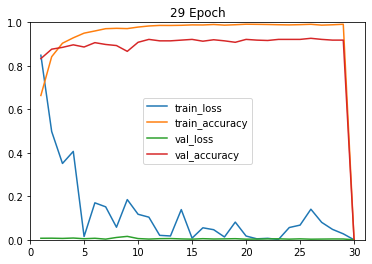

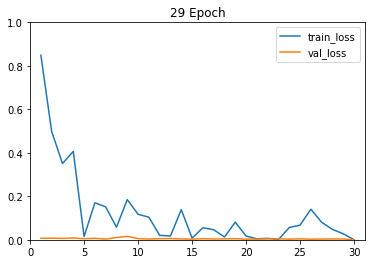

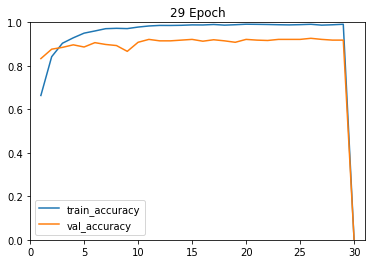

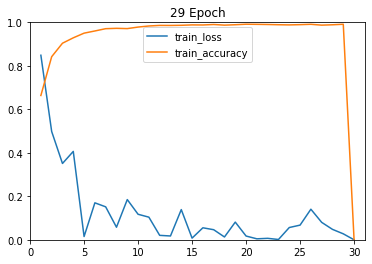

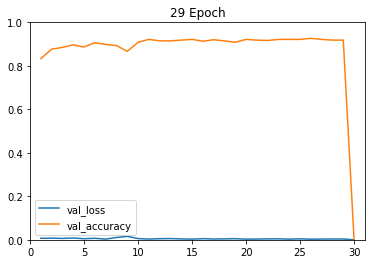

Train Epoch: 29 [0/5400 (0)%]\Loss 0.056945
Train Epoch: 29 [320/5400 (6)%]\Loss 0.011157
Train Epoch: 29 [640/5400 (12)%]\Loss 0.029008
Train Epoch: 29 [960/5400 (18)%]\Loss 0.013198
Train Epoch: 29 [1280/5400 (24)%]\Loss 0.049636
Train Epoch: 29 [1600/5400 (30)%]\Loss 0.010847
Train Epoch: 29 [1920/5400 (36)%]\Loss 0.066213
Train Epoch: 29 [2240/5400 (41)%]\Loss 0.035809
Train Epoch: 29 [2560/5400 (47)%]\Loss 0.008309
Train Epoch: 29 [2880/5400 (53)%]\Loss 0.042619
Train Epoch: 29 [3200/5400 (59)%]\Loss 0.015951
Train Epoch: 29 [3520/5400 (65)%]\Loss 0.008117
Train Epoch: 29 [3840/5400 (71)%]\Loss 0.117811
Train Epoch: 29 [4160/5400 (77)%]\Loss 0.010088
Train Epoch: 29 [4480/5400 (83)%]\Loss 0.013149
Train Epoch: 29 [4800/5400 (89)%]\Loss 0.069476
Train Epoch: 29 [5120/5400 (95)%]\Loss 0.048291
[29] Test Loss: 0.0038, Accuracy: 92.3333%


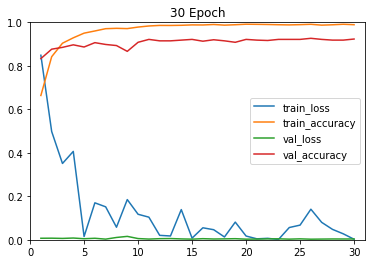

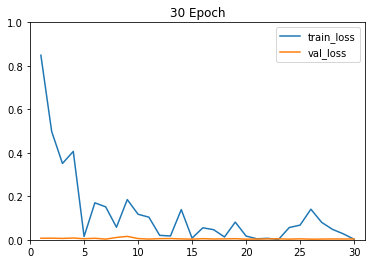

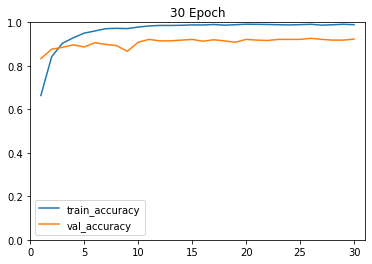

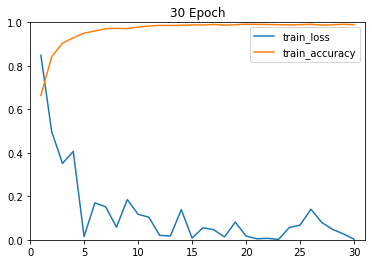

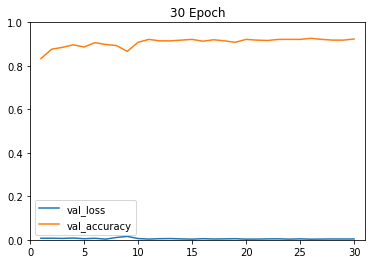

Finish Train
Best Accuracy:  92.66666666666667
Time: 1h, 63m, 33.05057644844055s


In [13]:
import time
start = time.time()
best = 0
for epoch in range(EPOCH):
    train(model, train_loader, optimizer, epoch)
    test_loss, test_accuracy = evaluate(model, val_loader, epoch)
    scheduler.step()
    if test_accuracy > best:
        best = test_accuracy
        torch.save(model.state_dict(), './best_model.pth')
    print('[{}] Test Loss: {:.4f}, Accuracy: {:.4f}%'.format(epoch, test_loss, test_accuracy))

    # Save and plot statistics
    np.save(os.path.join('./', 'train_loss.npy'), train_loss)
    np.save(os.path.join('./', 'train_accuracy.npy'), train_accuracy)
    np.save(os.path.join('./', 'val_loss.npy'), val_loss)
    np.save(os.path.join('./', 'val_accuracy.npy'), val_accuracy)

    %matplotlib inline
    plt.figure()
    plt.title('{} Epoch'.format(epoch+1))
    pylab.xlim(0, EPOCH + 1)
    pylab.ylim(0, 1)
    plt.plot(range(1, EPOCH + 1), train_loss, label='train_loss')
    plt.plot(range(1, EPOCH + 1), train_accuracy, label='train_accuracy')
    plt.plot(range(1, EPOCH + 1), val_loss, label='val_loss')
    plt.plot(range(1, EPOCH + 1), val_accuracy, label='val_accuracy')
    plt.legend()
    plt.savefig(os.path.join('./', 'lossAndAccuracy.pdf'))
    plt.show()
    plt.close()
    
    %matplotlib inline
    plt.figure()
    plt.title('{} Epoch'.format(epoch+1))
    pylab.xlim(0, EPOCH + 1)
    pylab.ylim(0, 1)
    plt.plot(range(1, EPOCH + 1), train_loss, label='train_loss')
    plt.plot(range(1, EPOCH + 1), val_loss, label='val_loss')
    plt.legend()
    plt.savefig(os.path.join('./', 'loss.pdf'))
    plt.show()
    plt.close()
    
    %matplotlib inline
    plt.figure()
    plt.title('{} Epoch'.format(epoch+1))
    pylab.xlim(0, EPOCH + 1)
    pylab.ylim(0, 1)
    plt.plot(range(1, EPOCH + 1), train_accuracy, label='train_accuracy')
    plt.plot(range(1, EPOCH + 1), val_accuracy, label='val_accuracy')
    plt.legend()
    plt.savefig(os.path.join('./', 'accuracy.pdf'))
    plt.show()
    plt.close()
    
    %matplotlib inline
    plt.figure()
    plt.title('{} Epoch'.format(epoch+1))
    pylab.xlim(0, EPOCH + 1)
    pylab.ylim(0, 1)
    plt.plot(range(1, EPOCH + 1), train_loss, label='train_loss')
    plt.plot(range(1, EPOCH + 1), train_accuracy, label='train_accuracy')
    plt.legend()
    plt.savefig(os.path.join('./', 'train_lossAndAccuracy.pdf'))
    plt.show()
    plt.close()
    
    %matplotlib inline
    plt.figure()
    plt.title('{} Epoch'.format(epoch+1))
    pylab.xlim(0, EPOCH + 1)
    pylab.ylim(0, 1)
    plt.plot(range(1, EPOCH + 1), val_loss, label='val_loss')
    plt.plot(range(1, EPOCH + 1), val_accuracy, label='val_accuracy')
    plt.legend()
    plt.savefig(os.path.join('./', 'val_lossAndAccuracy.pdf'))
    plt.show()
    plt.close()

    
end = time.time()
time = end - start
    
print('Finish Train')
print('Best Accuracy: ', best)
print('Time: {}h, {}m, {}s'.format(int(time/3600), int(time/60), time%60))

# Test & Save the predicted value as a CSV file

In [14]:
import csv

load = torch.load('./best_model.pth')
model.load_state_dict(load)
model.eval()
print('load model for test set')

f = open('./prediction.csv', 'w', newline="")
w = csv.writer(f)
w.writerow(['id', 'target'])

test_set = MyDataset('../input/yoga-classification-dataset/test', 0, get_transform(True), test=True)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

preds = []
img_ids = []
correct = 0
with torch.no_grad():
    for (image, image_name) in test_loader:
        image = image.to(DEVICE)
        output = model(image)
        
        pred = output.max(1, keepdim=True)[1]
        preds.extend(pred)
        img_ids.extend(image_name)
        
for i in range(600):
    w.writerow([img_ids[i][:-4], str(preds[i].item())])
    
f.close()
print('save prediction csv')

load model for test set
save prediction csv
